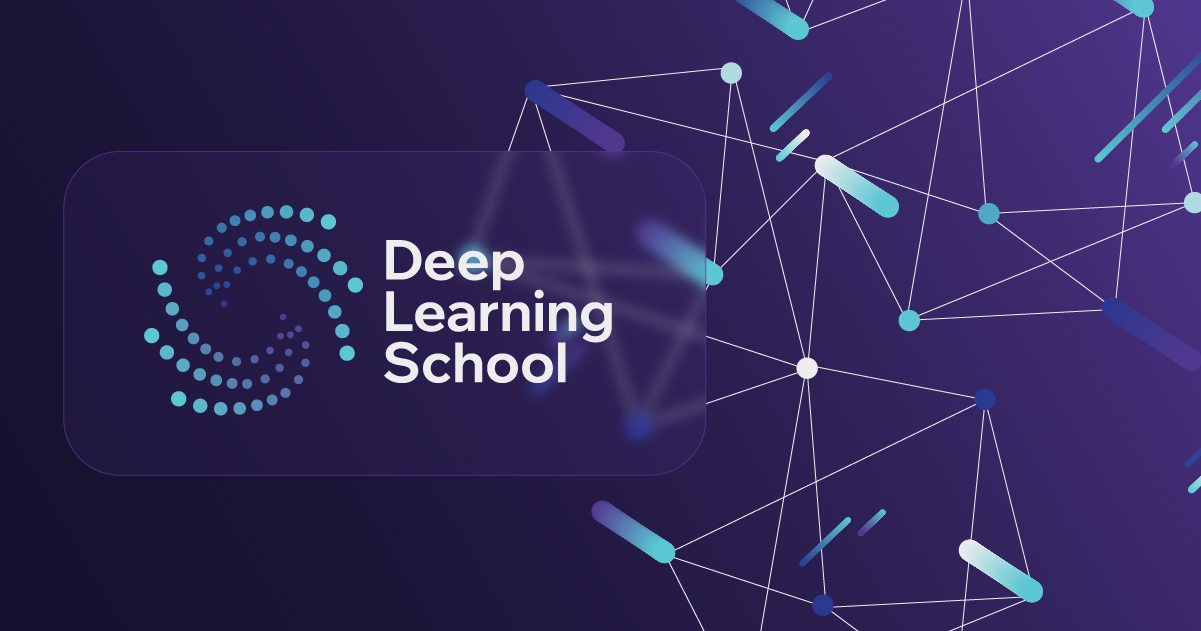


# Домашнее задание "Варианционные автоэнкодеры"

В этом домашнем задании вам предстоит реализовать несколько версий автоэнкодера для работы с изображениями.

Вы научитесь добавлять улыбку на фотографии людей, изменяя их исходное выражение лица с помощью обученной модели. А также, обучите ваш автоэнкодер генерировать изображения рукописных цифр.

# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


Перед тем, как начинать работу с моделями нужно подготовить данные.

In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm

import os
import pandas as pd
import skimage.io
from skimage.transform import resize

import imageio
from PIL import Image
import kagglehub

%matplotlib inline

В этом задании вам предстоить работать с датасетом [LFW (Labeled Faces in the Wild)](https://datasets.activeloop.ai/docs/ml/datasets/lfw-dataset/#:~:text=What%20is%20LFW%20Dataset%3F,commercial%20algorithms%20prior%20to%20release).

In [3]:
# Скачиваем картинки
images_path = kagglehub.dataset_download("jessicali9530/lfw-dataset")
print("Path to dataset files:", images_path)

Using Colab cache for faster access to the 'lfw-dataset' dataset.
Path to dataset files: /kaggle/input/lfw-dataset


In [4]:
# Скачиваем атрибуты
attrs_path = kagglehub.dataset_download("averkij/lfw-attributes")
print("Path to dataset files:", attrs_path)

Using Colab cache for faster access to the 'lfw-attributes' dataset.
Path to dataset files: /kaggle/input/lfw-attributes


In [5]:
DATASET_PATH ="/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/"
ATTRIBUTES_PATH = "/kaggle/input/lfw-attributes/lfw_attributes.txt"

In [6]:
def fetch_dataset(dx=80, dy=80, dimx=45, dimy=45):

    df_attrs = pd.read_csv(ATTRIBUTES_PATH, sep='\t', skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns = df_attrs.columns[1:])

    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath, fname)
                photo_id = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person': person_id,'imagenum': photo_number, 'photo_path': fpath})

    photo_ids = pd.DataFrame(photo_ids)
    df = pd.merge(df_attrs,photo_ids,on=('person', 'imagenum'))

    assert len(df) == len(df_attrs), "Потеряны данные при объединении датафреймов!"

    images = df['photo_path'].apply(imageio.imread)\
                                .apply(lambda img:img[dy:-dy, dx:-dx])\
                                .apply(lambda img: np.array(Image.fromarray(img).resize([dimx, dimy])) )

    images = np.stack(images.values).astype('uint8')
    attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return images, attrs

In [7]:
# Обратите внимание, что датасет представляет собой не только картинки, но и атрибуты
# Атрибуты понадобятся в конце этого задания

images, attrs = fetch_dataset()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



Разбейте датасет изображений и атрибутов на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

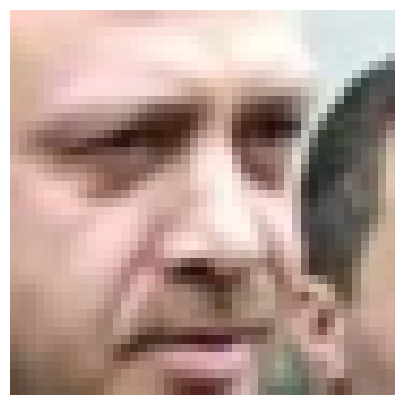

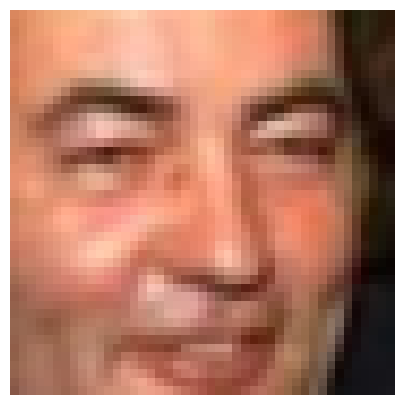

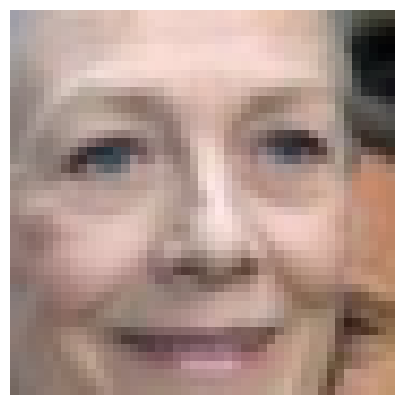

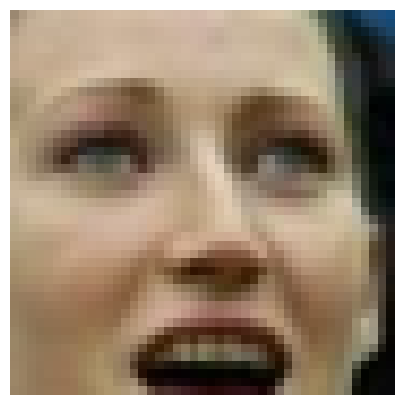

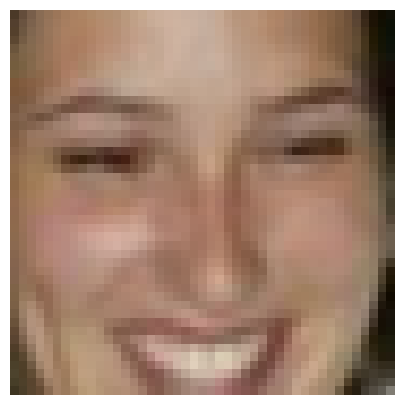

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(images, test_size=0.2, random_state=42)

def show_img(ndarray):
  img = np.asarray(ndarray)
  plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.axis("off")
  plt.show()

for i in range(5):
  show_img(X_train[i])

In [33]:
print(X_train.shape)
X_train = torch.from_numpy(X_train).permute(0, 3, 1, 2).float() / 255.0
X_val = torch.from_numpy(X_val).permute(0, 3, 1, 2).float() / 255.0
print(X_train.shape)

(10514, 45, 45, 3)
torch.Size([10514, 3, 45, 45])


## 1.2. Архитектура модели (2 балла)
В этом разделе вы напишите и обучите обычный автоэнкодер.



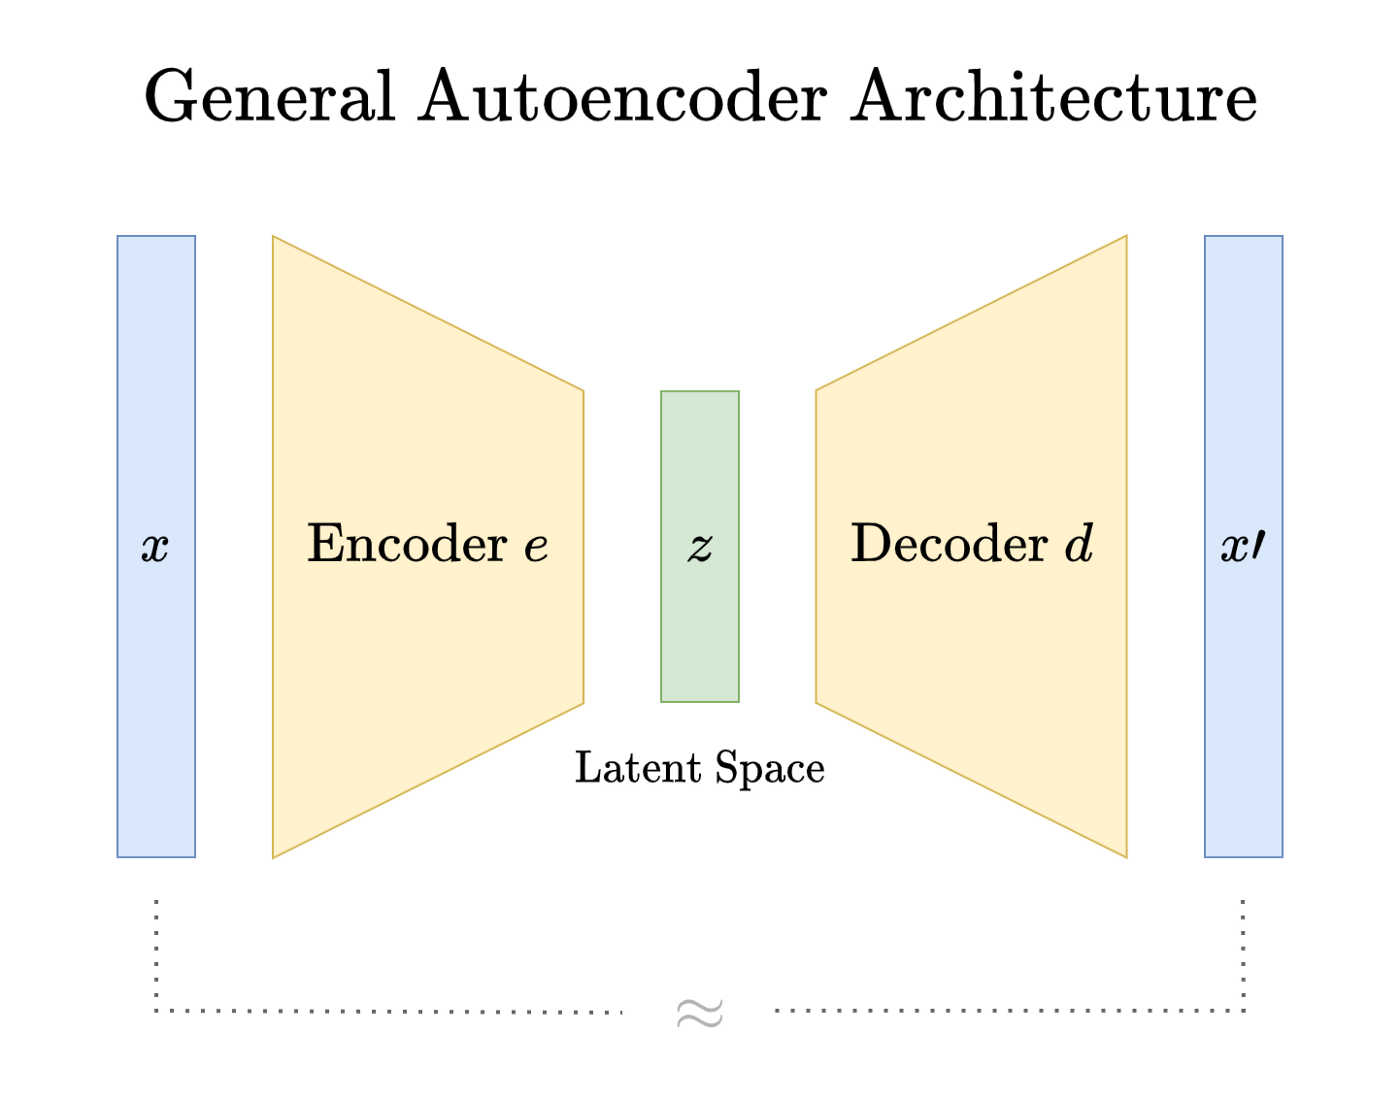

In [34]:
dim_code = 128

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [35]:
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 128, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstruction = self.decoder(latent)
        return reconstruction, latent


In [36]:
from torch.utils.data import DataLoader
train_loader = DataLoader(X_train, 128)
val_loader = DataLoader(X_val, 128)
loaders = {"train" : train_loader,
           "val" : val_loader,
           }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

autoencoder = Autoencoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэнкодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

100%|██████████| 83/83 [00:00<00:00, 125.22it/s]


EPOCH: 1 | PHASE: TRAIN | LOSS: 0.02335627116711743
EPOCH: 1 | PHASE: TRAIN | LOSS: 0.025632267640460105


100%|██████████| 83/83 [00:00<00:00, 130.07it/s]


EPOCH: 2 | PHASE: TRAIN | LOSS: 0.024138497592634464
EPOCH: 2 | PHASE: TRAIN | LOSS: 0.023325805596652486


100%|██████████| 83/83 [00:00<00:00, 129.27it/s]


EPOCH: 3 | PHASE: TRAIN | LOSS: 0.019635778795703347
EPOCH: 3 | PHASE: TRAIN | LOSS: 0.017840308536376272


100%|██████████| 83/83 [00:00<00:00, 130.24it/s]


EPOCH: 4 | PHASE: TRAIN | LOSS: 0.0176901661353298
EPOCH: 4 | PHASE: TRAIN | LOSS: 0.01893113704309577


100%|██████████| 83/83 [00:00<00:00, 127.72it/s]

EPOCH: 5 | PHASE: TRAIN | LOSS: 0.020796470119651543


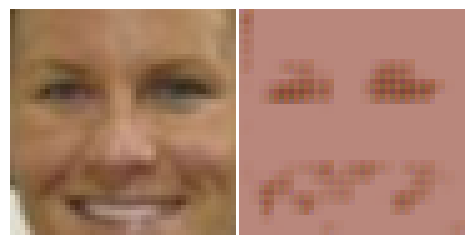

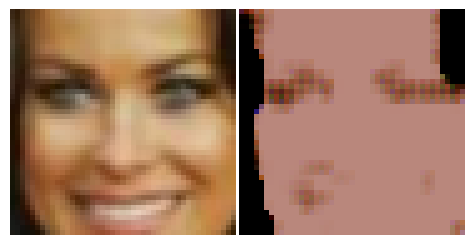

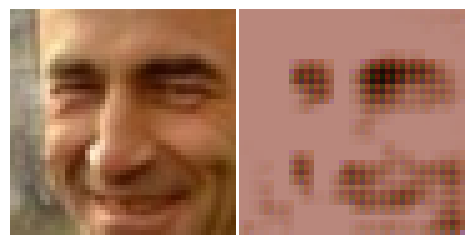

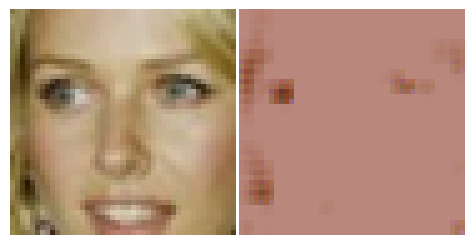

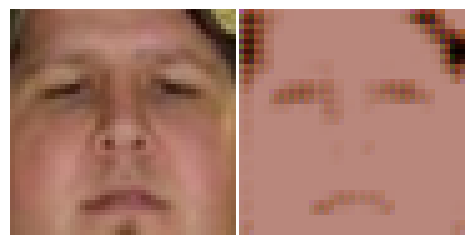

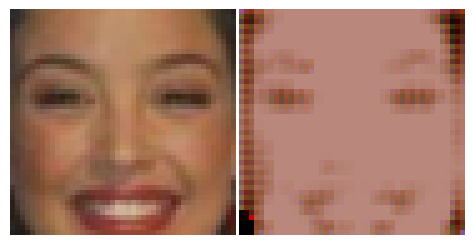

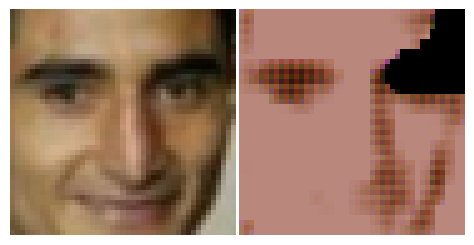

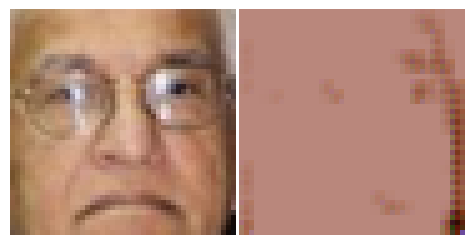

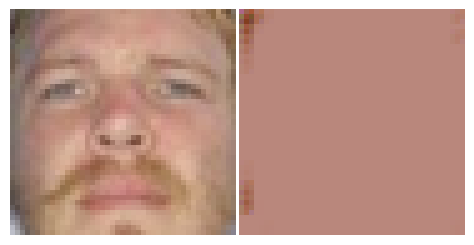

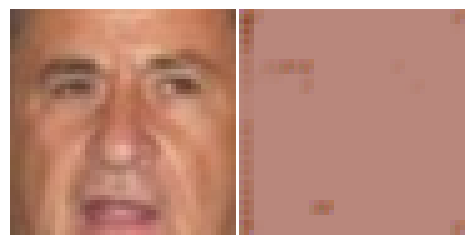

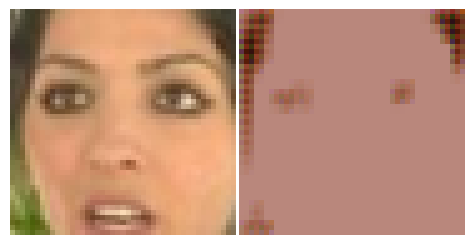

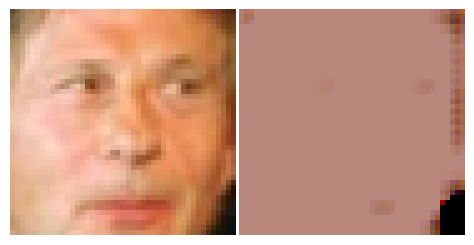

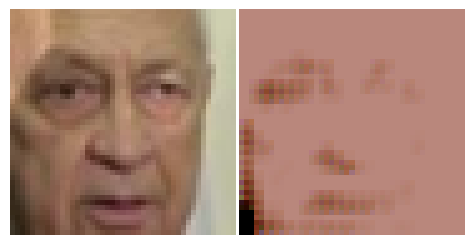

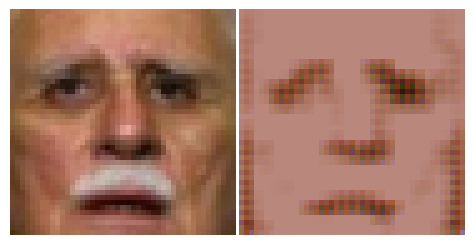

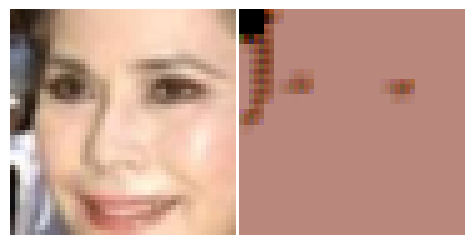

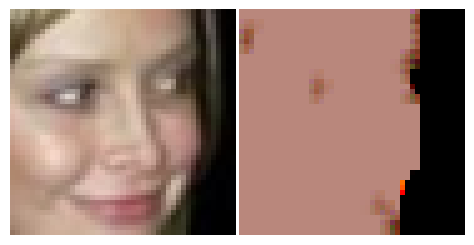

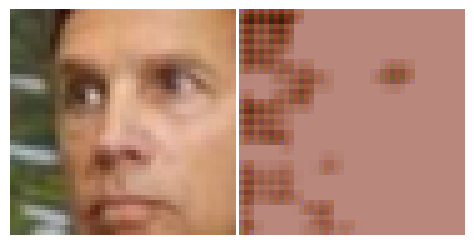

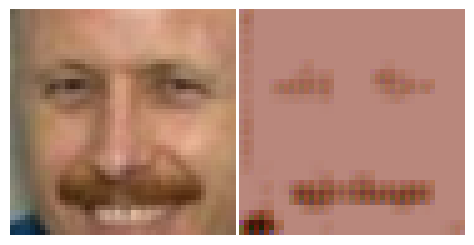

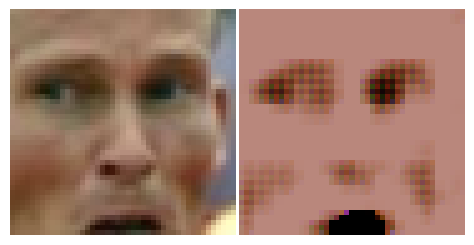

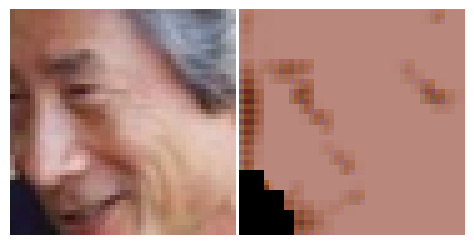

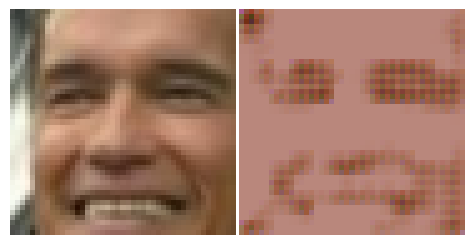

EPOCH: 5 | PHASE: TRAIN | LOSS: 0.021631431632808278


100%|██████████| 83/83 [00:00<00:00, 127.78it/s]


EPOCH: 6 | PHASE: TRAIN | LOSS: 0.021048914596258878
EPOCH: 6 | PHASE: TRAIN | LOSS: 0.018766368961050398


100%|██████████| 83/83 [00:00<00:00, 127.68it/s]


EPOCH: 7 | PHASE: TRAIN | LOSS: 0.01638981787465423
EPOCH: 7 | PHASE: TRAIN | LOSS: 0.01520834690225976


100%|██████████| 83/83 [00:00<00:00, 129.27it/s]


EPOCH: 8 | PHASE: TRAIN | LOSS: 0.017038521031478803
EPOCH: 8 | PHASE: TRAIN | LOSS: 0.021002111956477165


100%|██████████| 83/83 [00:00<00:00, 130.35it/s]


EPOCH: 9 | PHASE: TRAIN | LOSS: 0.022518090881317496
EPOCH: 9 | PHASE: TRAIN | LOSS: 0.024176172557331267


100%|██████████| 83/83 [00:00<00:00, 131.03it/s]

EPOCH: 10 | PHASE: TRAIN | LOSS: 0.021177000310047562


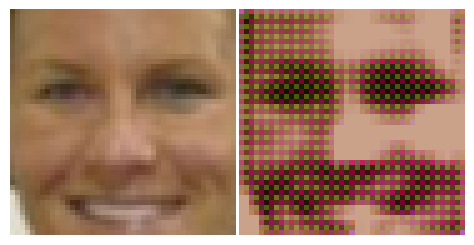

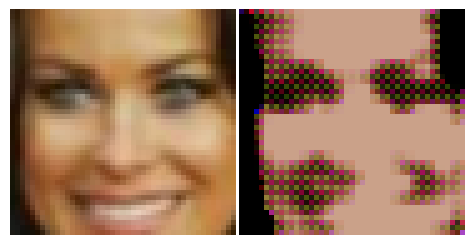

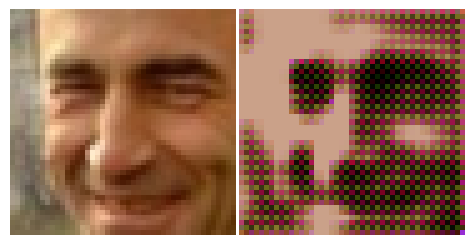

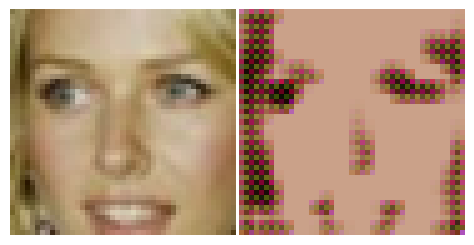

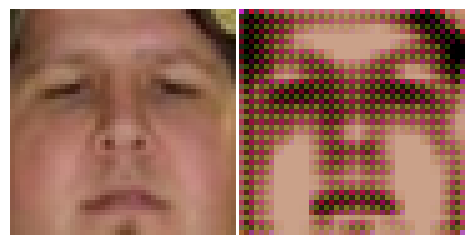

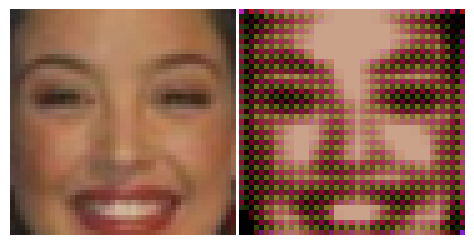

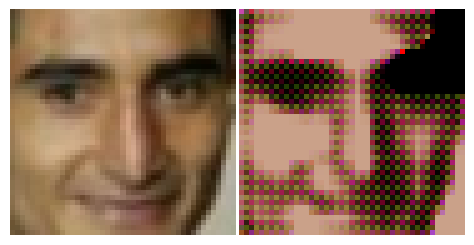

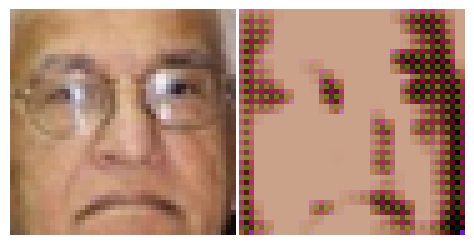

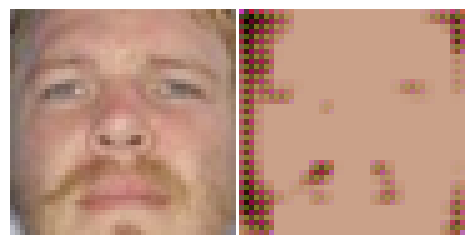

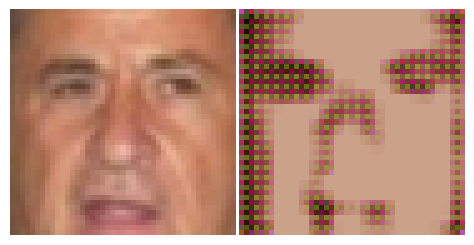

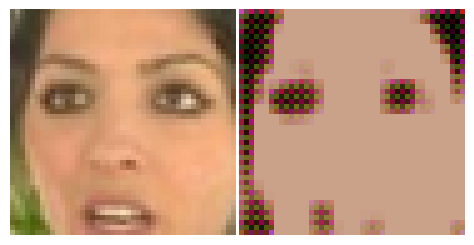

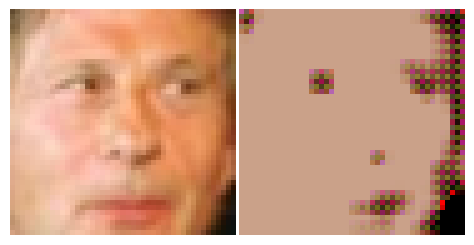

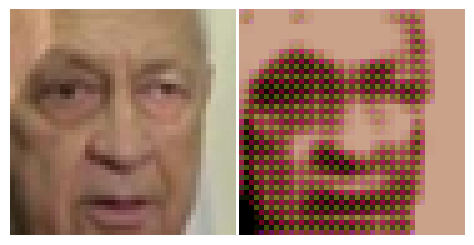

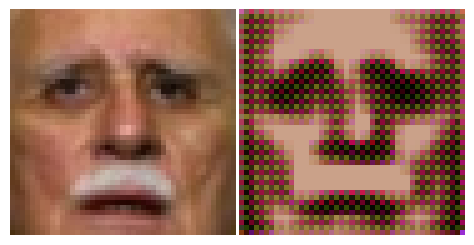

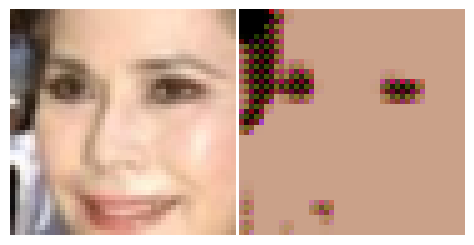

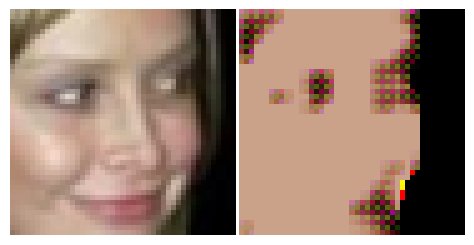

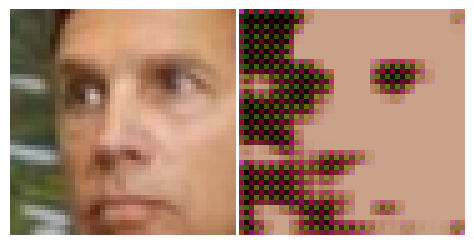

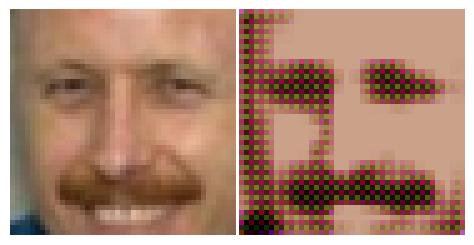

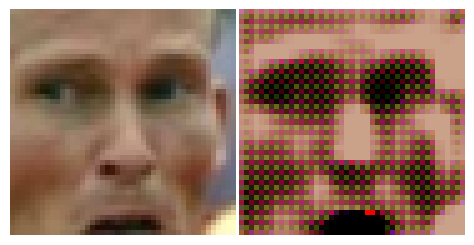

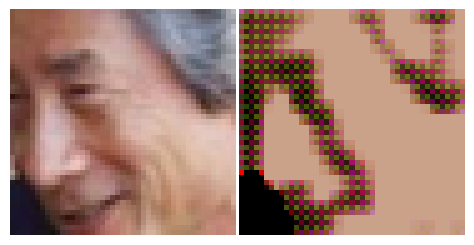

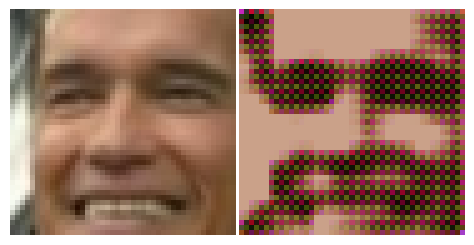

EPOCH: 10 | PHASE: TRAIN | LOSS: 0.019261095140661513


100%|██████████| 83/83 [00:00<00:00, 127.70it/s]


EPOCH: 11 | PHASE: TRAIN | LOSS: 0.0179380912737674
EPOCH: 11 | PHASE: TRAIN | LOSS: 0.018902850115583056


100%|██████████| 83/83 [00:00<00:00, 129.54it/s]


EPOCH: 12 | PHASE: TRAIN | LOSS: 0.022477273683411528
EPOCH: 12 | PHASE: TRAIN | LOSS: 0.024520313101155416


100%|██████████| 83/83 [00:00<00:00, 128.15it/s]


EPOCH: 13 | PHASE: TRAIN | LOSS: 0.02470149077385305
EPOCH: 13 | PHASE: TRAIN | LOSS: 0.021621692925691605


100%|██████████| 83/83 [00:00<00:00, 129.36it/s]


EPOCH: 14 | PHASE: TRAIN | LOSS: 0.01851306036563523
EPOCH: 14 | PHASE: TRAIN | LOSS: 0.016649273445918447


100%|██████████| 83/83 [00:00<00:00, 127.99it/s]

EPOCH: 15 | PHASE: TRAIN | LOSS: 0.018718228821294855


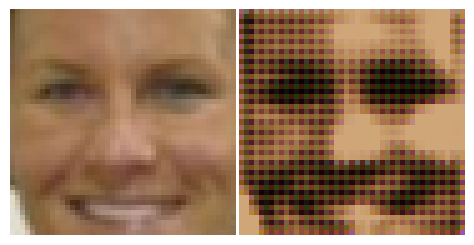

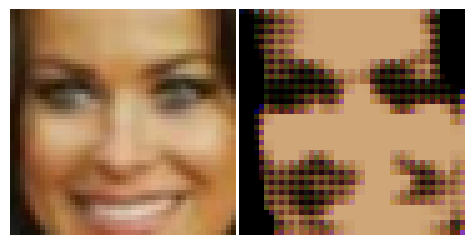

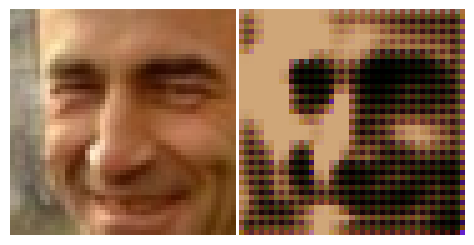

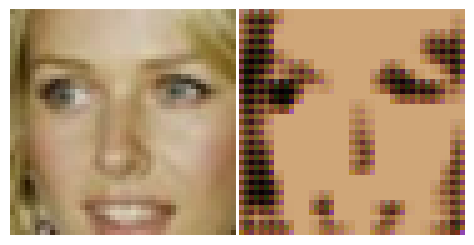

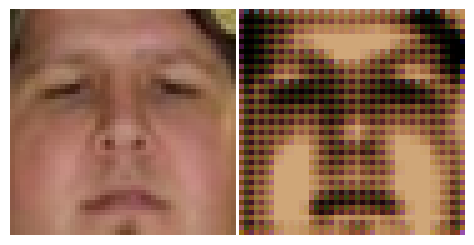

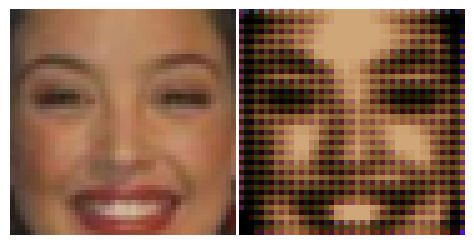

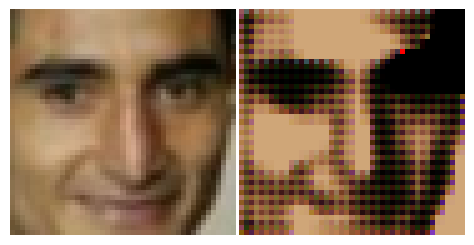

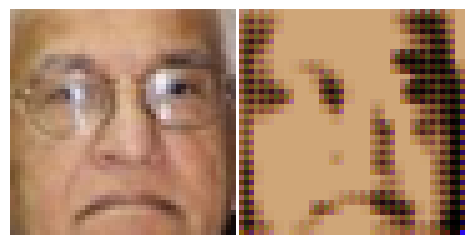

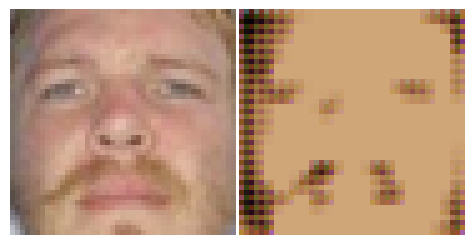

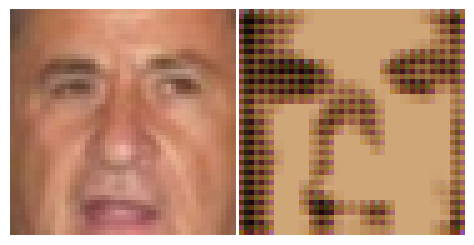

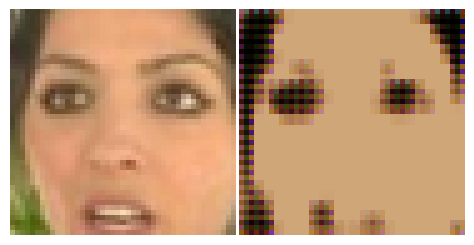

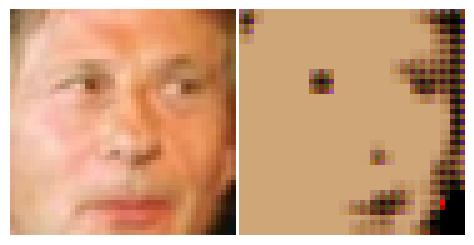

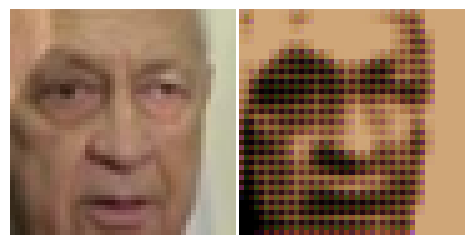

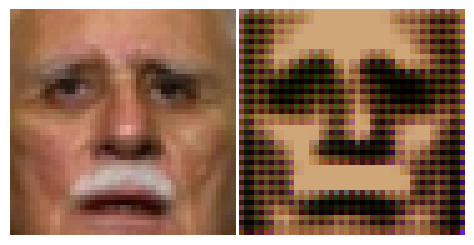

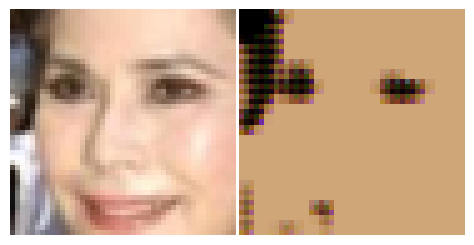

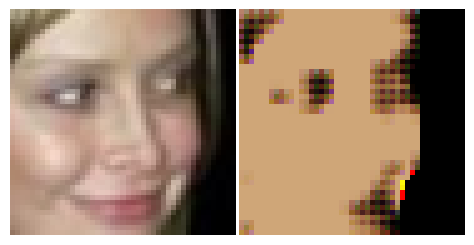

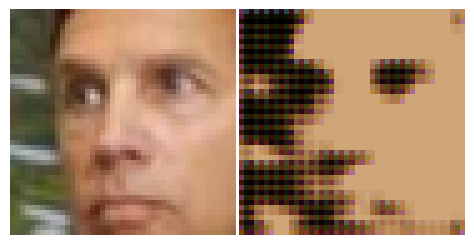

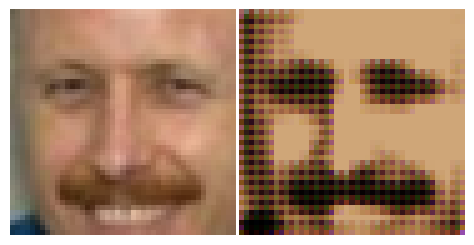

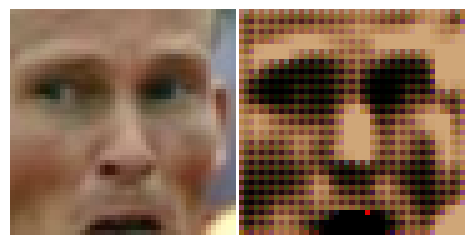

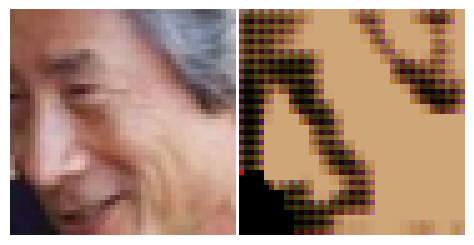

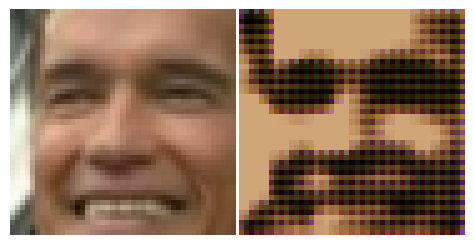

EPOCH: 15 | PHASE: TRAIN | LOSS: 0.02317880590756734


100%|██████████| 83/83 [00:00<00:00, 126.92it/s]


EPOCH: 16 | PHASE: TRAIN | LOSS: 0.02438964950571577
EPOCH: 16 | PHASE: TRAIN | LOSS: 0.025420877639026868


100%|██████████| 83/83 [00:00<00:00, 126.53it/s]


EPOCH: 17 | PHASE: TRAIN | LOSS: 0.020494231460503786
EPOCH: 17 | PHASE: TRAIN | LOSS: 0.01704866767284416


100%|██████████| 83/83 [00:00<00:00, 130.77it/s]


EPOCH: 18 | PHASE: TRAIN | LOSS: 0.015259351547672806
EPOCH: 18 | PHASE: TRAIN | LOSS: 0.016461460318948542


100%|██████████| 83/83 [00:00<00:00, 126.38it/s]


EPOCH: 19 | PHASE: TRAIN | LOSS: 0.01996064560869372
EPOCH: 19 | PHASE: TRAIN | LOSS: 0.02245874809367316


100%|██████████| 83/83 [00:00<00:00, 129.06it/s]

EPOCH: 20 | PHASE: TRAIN | LOSS: 0.023446286456233048


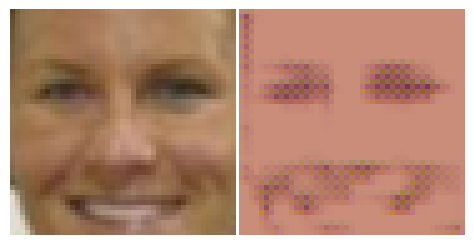

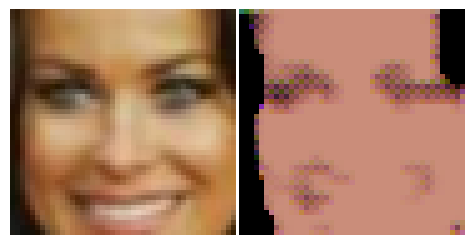

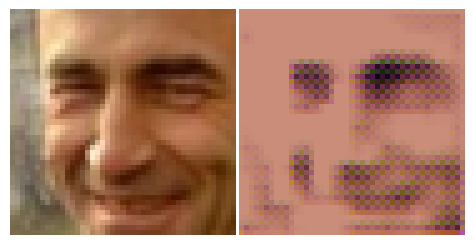

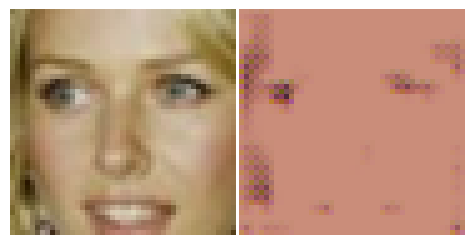

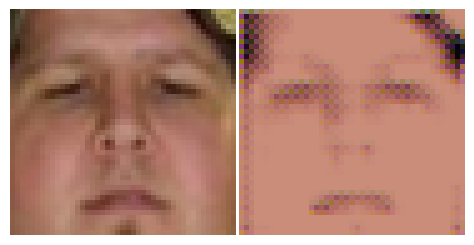

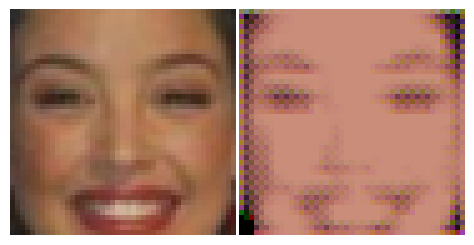

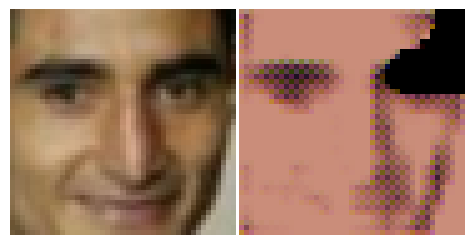

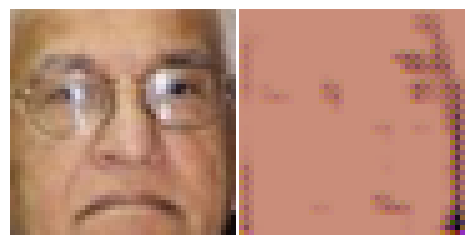

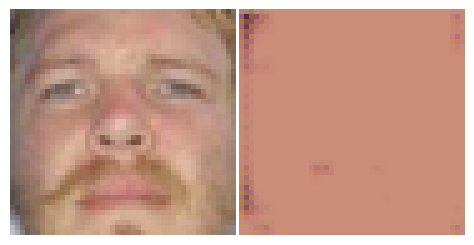

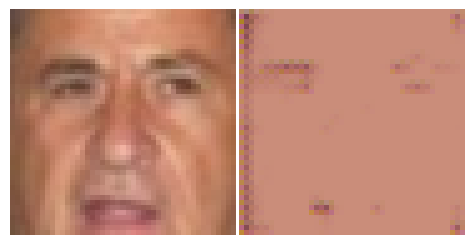

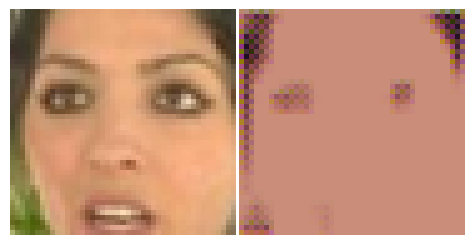

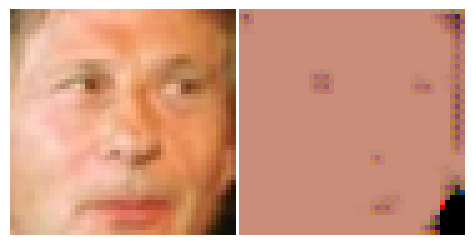

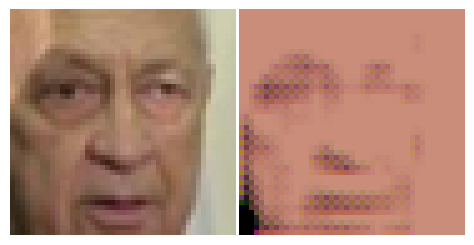

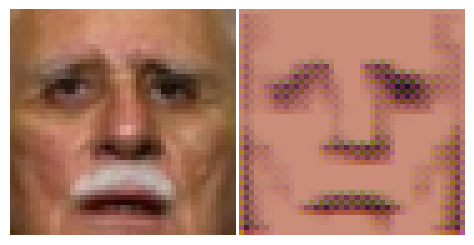

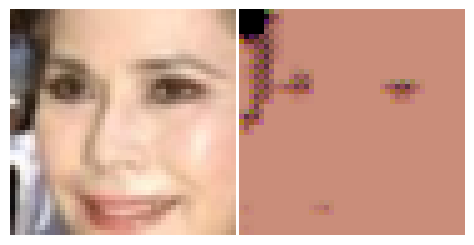

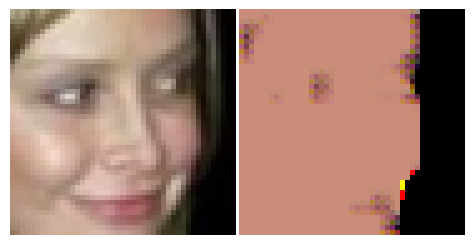

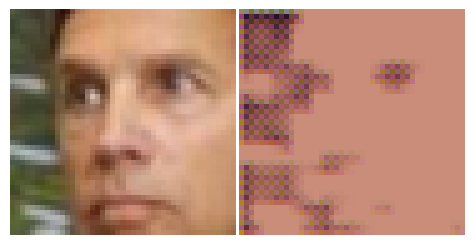

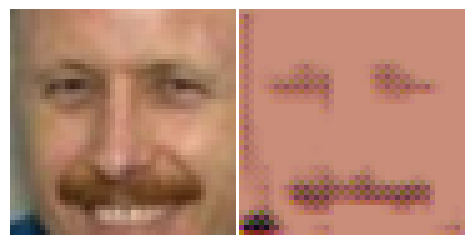

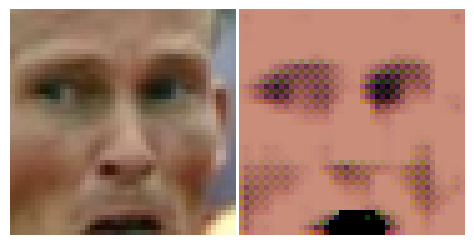

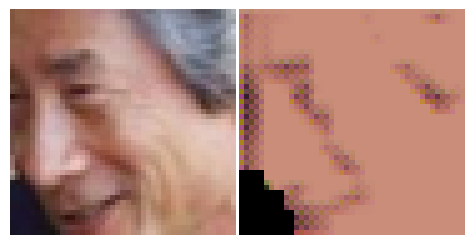

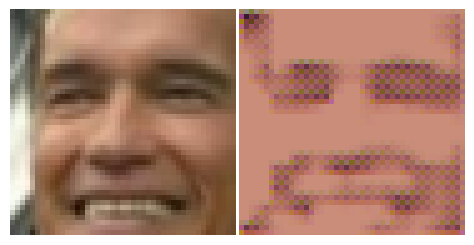

EPOCH: 20 | PHASE: TRAIN | LOSS: 0.022479438888175145


100%|██████████| 83/83 [00:00<00:00, 129.42it/s]


EPOCH: 21 | PHASE: TRAIN | LOSS: 0.0203558833349541
EPOCH: 21 | PHASE: TRAIN | LOSS: 0.017622626963115874


100%|██████████| 83/83 [00:00<00:00, 129.66it/s]


EPOCH: 22 | PHASE: TRAIN | LOSS: 0.01622303975858243
EPOCH: 22 | PHASE: TRAIN | LOSS: 0.016745571845344136


100%|██████████| 83/83 [00:00<00:00, 131.07it/s]


EPOCH: 23 | PHASE: TRAIN | LOSS: 0.01913680053170187
EPOCH: 23 | PHASE: TRAIN | LOSS: 0.023495768152532123


100%|██████████| 83/83 [00:00<00:00, 132.41it/s]


EPOCH: 24 | PHASE: TRAIN | LOSS: 0.024795664362160557
EPOCH: 24 | PHASE: TRAIN | LOSS: 0.026313203874798047


100%|██████████| 83/83 [00:00<00:00, 132.28it/s]

EPOCH: 25 | PHASE: TRAIN | LOSS: 0.022951283323836613


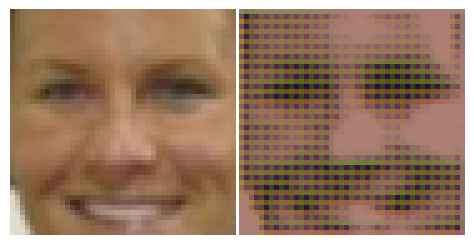

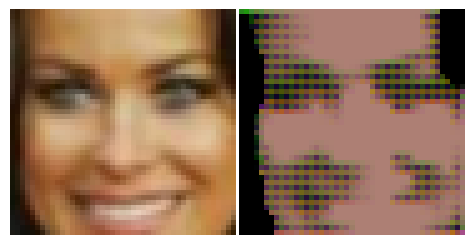

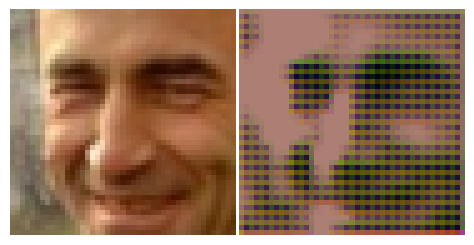

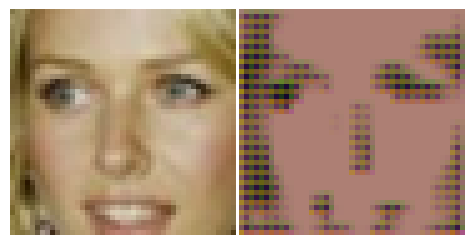

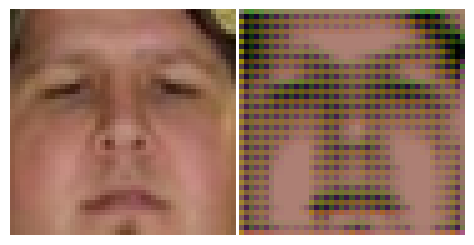

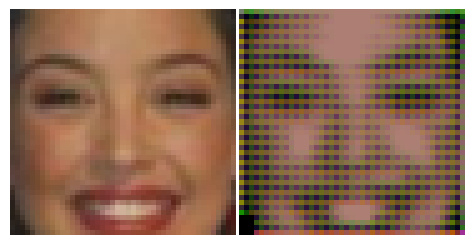

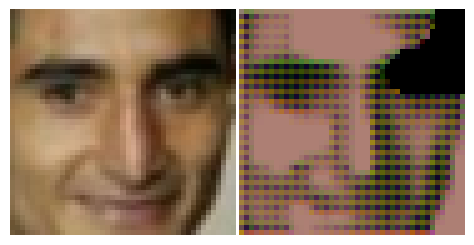

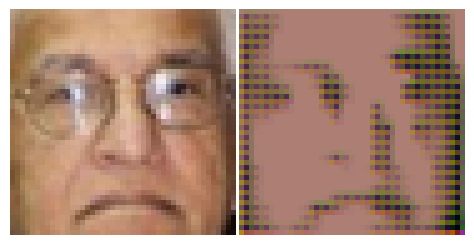

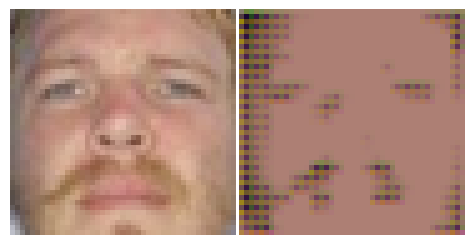

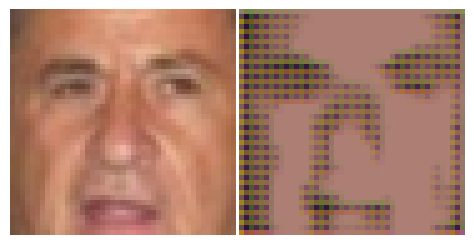

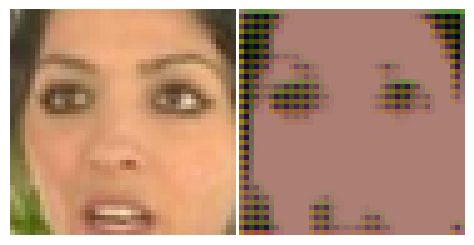

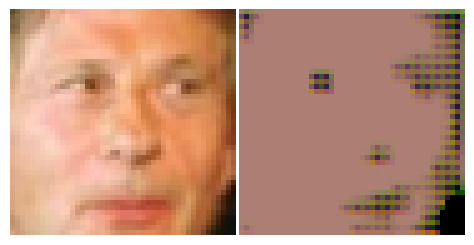

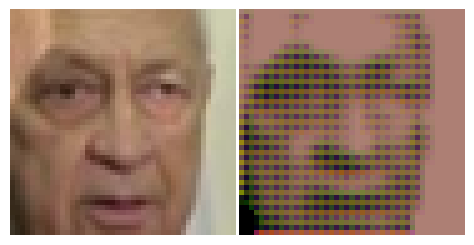

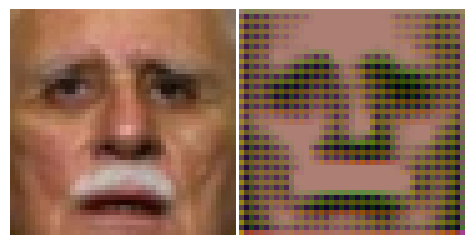

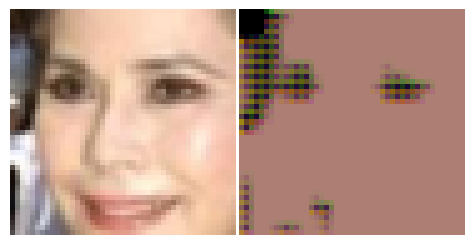

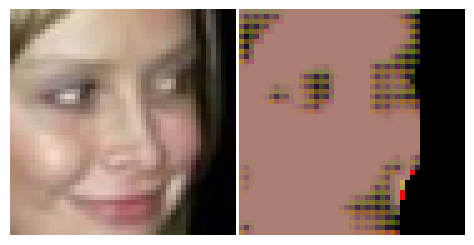

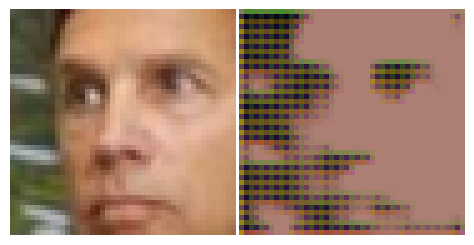

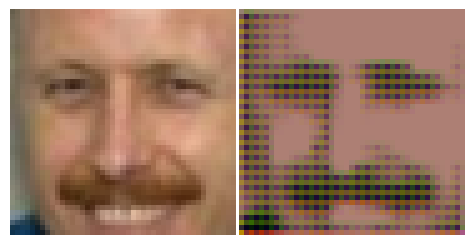

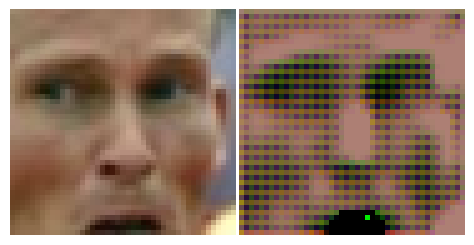

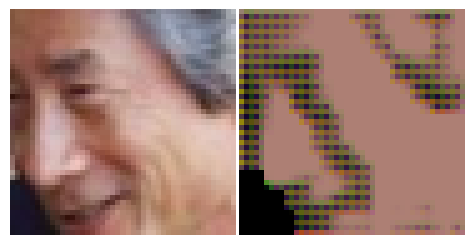

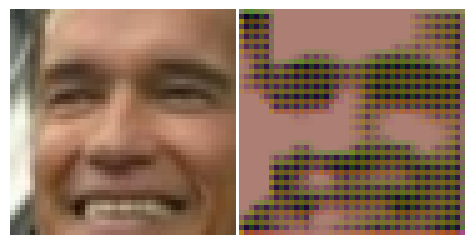

EPOCH: 25 | PHASE: TRAIN | LOSS: 0.02054057288027945


100%|██████████| 83/83 [00:00<00:00, 132.49it/s]


EPOCH: 26 | PHASE: TRAIN | LOSS: 0.01771564982517297
EPOCH: 26 | PHASE: TRAIN | LOSS: 0.0170879325873795


100%|██████████| 83/83 [00:00<00:00, 131.98it/s]


EPOCH: 27 | PHASE: TRAIN | LOSS: 0.01844222224261387
EPOCH: 27 | PHASE: TRAIN | LOSS: 0.020455897209190187


100%|██████████| 83/83 [00:00<00:00, 129.12it/s]


EPOCH: 28 | PHASE: TRAIN | LOSS: 0.022708544328090656
EPOCH: 28 | PHASE: TRAIN | LOSS: 0.023726241663098335


100%|██████████| 83/83 [00:00<00:00, 131.68it/s]


EPOCH: 29 | PHASE: TRAIN | LOSS: 0.023513634677931487
EPOCH: 29 | PHASE: TRAIN | LOSS: 0.02150104186009793


100%|██████████| 83/83 [00:00<00:00, 131.08it/s]

EPOCH: 30 | PHASE: TRAIN | LOSS: 0.018735463293381483


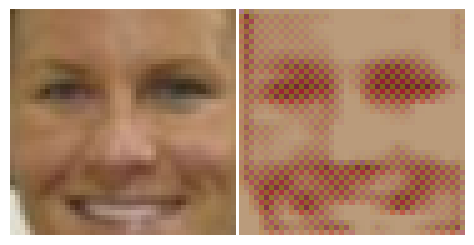

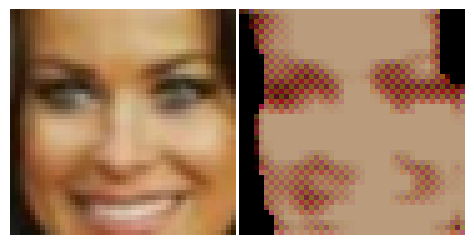

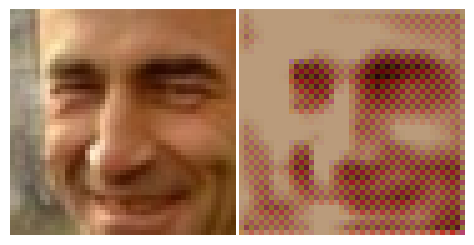

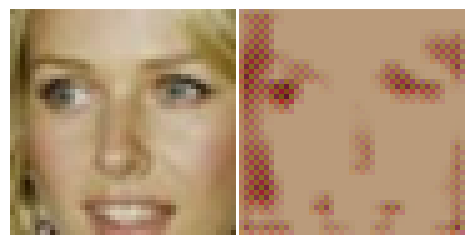

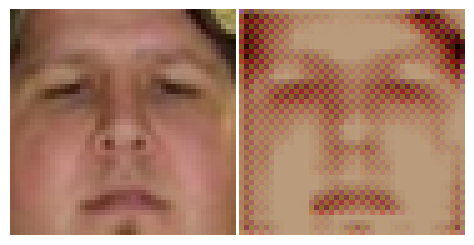

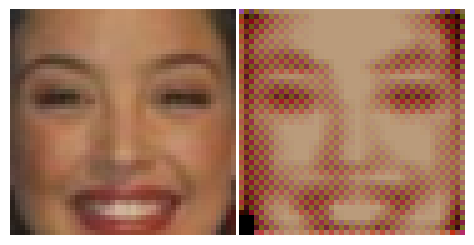

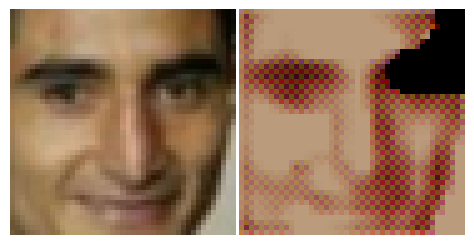

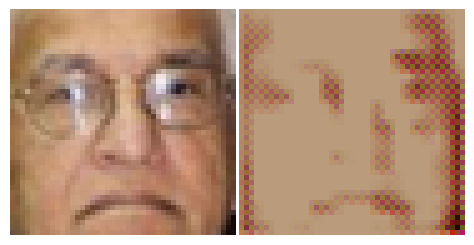

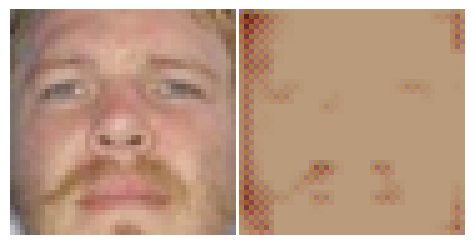

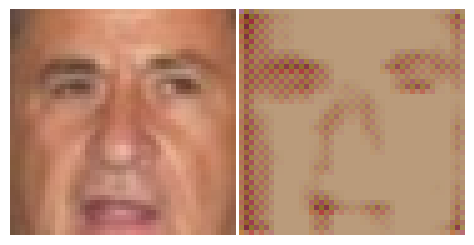

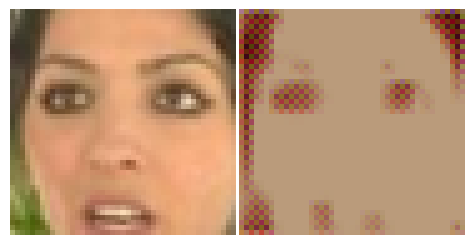

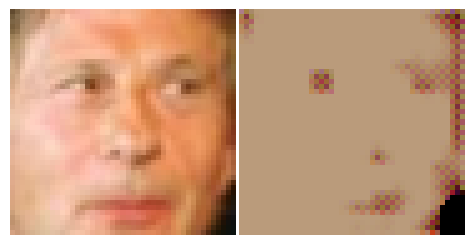

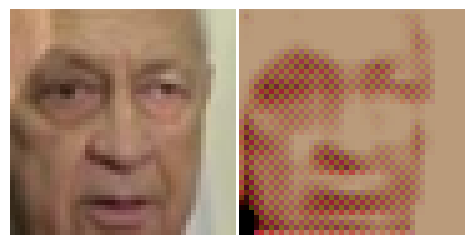

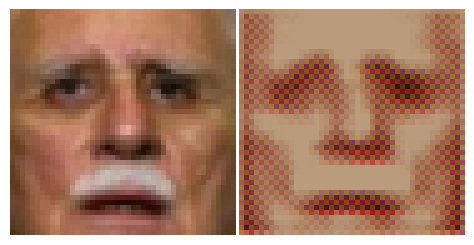

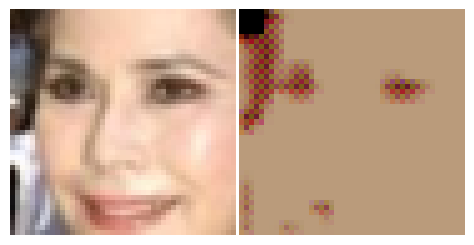

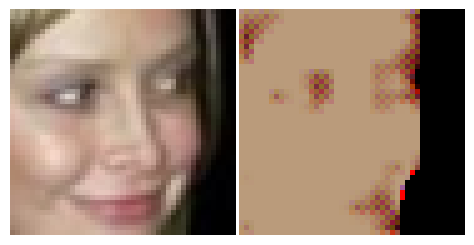

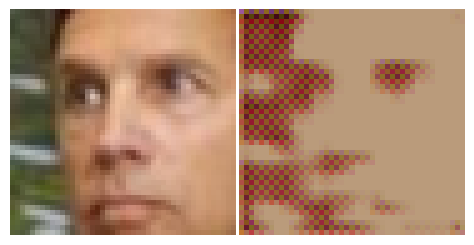

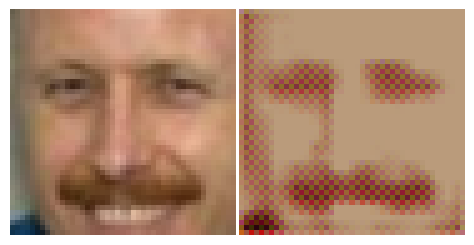

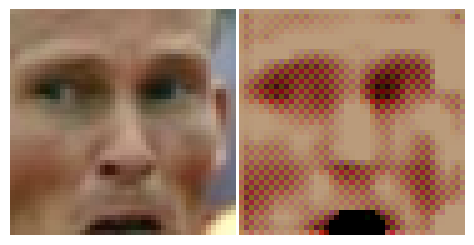

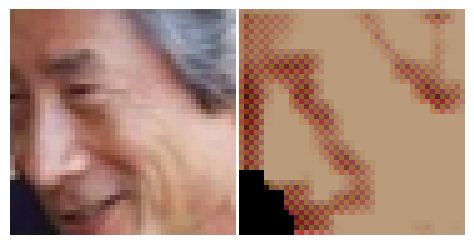

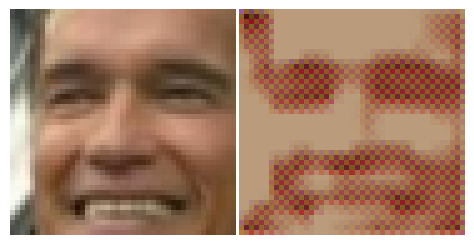

EPOCH: 30 | PHASE: TRAIN | LOSS: 0.015538836607620829


100%|██████████| 83/83 [00:00<00:00, 127.77it/s]


EPOCH: 31 | PHASE: TRAIN | LOSS: 0.01423333096037428
EPOCH: 31 | PHASE: TRAIN | LOSS: 0.015108360731530757


100%|██████████| 83/83 [00:00<00:00, 125.59it/s]


EPOCH: 32 | PHASE: TRAIN | LOSS: 0.017908208476132656
EPOCH: 32 | PHASE: TRAIN | LOSS: 0.022679433315282778


100%|██████████| 83/83 [00:00<00:00, 128.37it/s]


EPOCH: 33 | PHASE: TRAIN | LOSS: 0.023849093433783716
EPOCH: 33 | PHASE: TRAIN | LOSS: 0.025035048968025615


100%|██████████| 83/83 [00:00<00:00, 125.29it/s]


EPOCH: 34 | PHASE: TRAIN | LOSS: 0.02062805436820869
EPOCH: 34 | PHASE: TRAIN | LOSS: 0.017246996629096213


100%|██████████| 83/83 [00:00<00:00, 125.08it/s]

EPOCH: 35 | PHASE: TRAIN | LOSS: 0.014519285197448299


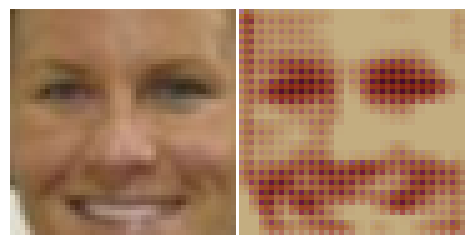

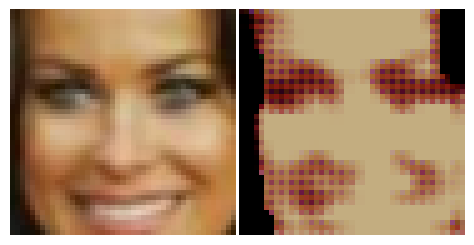

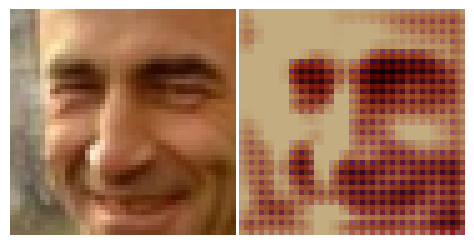

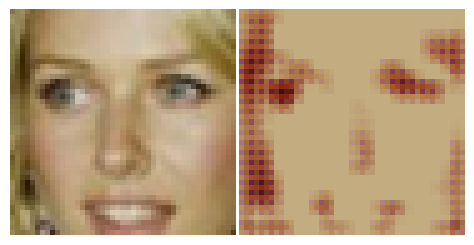

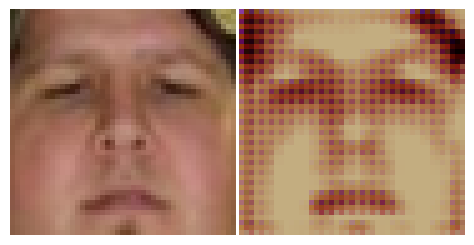

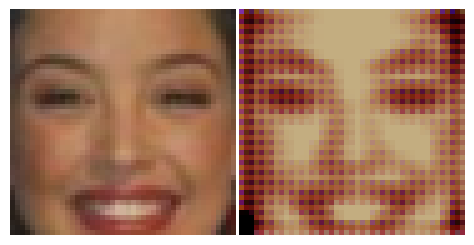

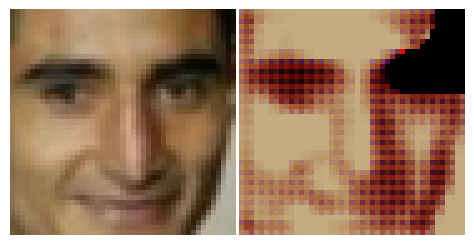

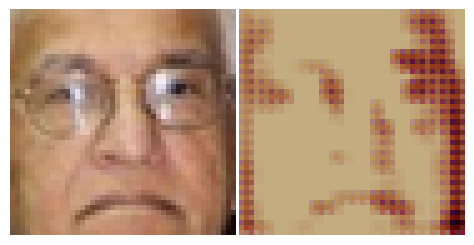

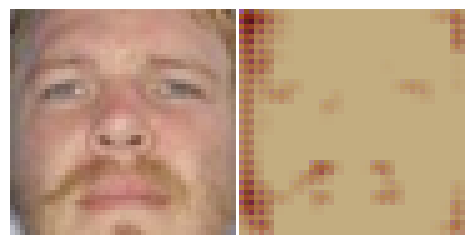

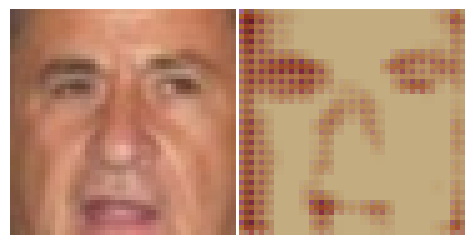

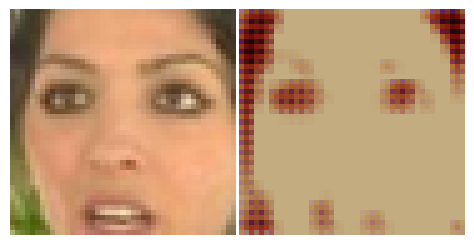

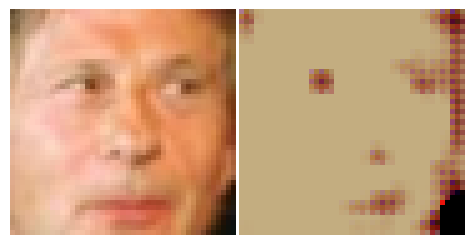

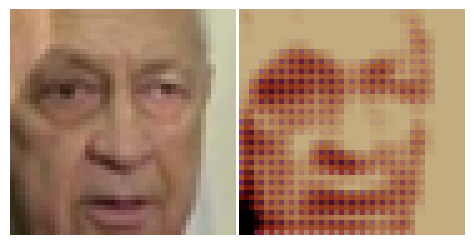

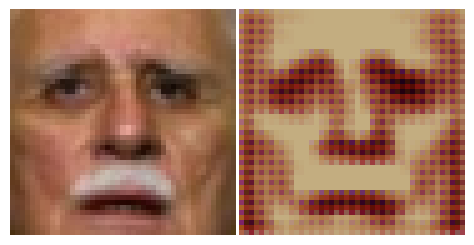

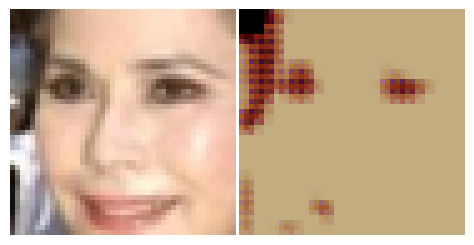

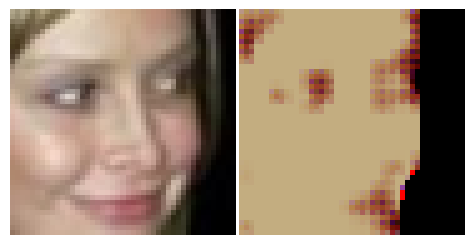

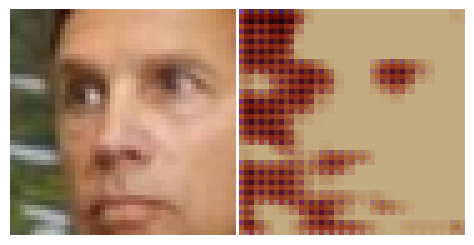

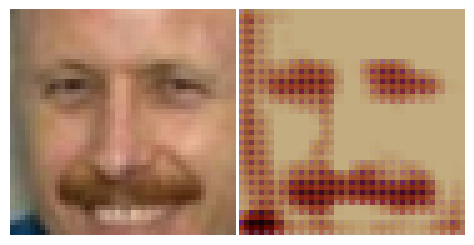

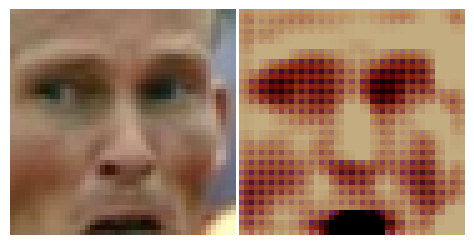

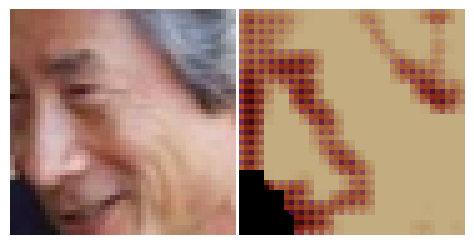

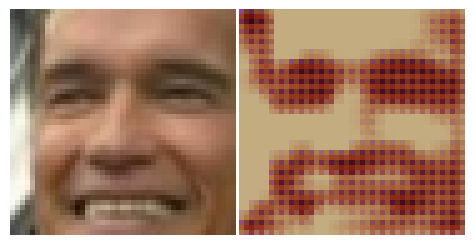

EPOCH: 35 | PHASE: TRAIN | LOSS: 0.01480164330097891


100%|██████████| 83/83 [00:00<00:00, 129.00it/s]


EPOCH: 36 | PHASE: TRAIN | LOSS: 0.01872719392315092
EPOCH: 36 | PHASE: TRAIN | LOSS: 0.022376539806524914


100%|██████████| 83/83 [00:00<00:00, 128.74it/s]


EPOCH: 37 | PHASE: TRAIN | LOSS: 0.025419047506279255
EPOCH: 37 | PHASE: TRAIN | LOSS: 0.025148455585752214


100%|██████████| 83/83 [00:00<00:00, 125.82it/s]


EPOCH: 38 | PHASE: TRAIN | LOSS: 0.02270826998065753
EPOCH: 38 | PHASE: TRAIN | LOSS: 0.017843736335635185


100%|██████████| 83/83 [00:00<00:00, 128.67it/s]


EPOCH: 39 | PHASE: TRAIN | LOSS: 0.015177281988582697
EPOCH: 39 | PHASE: TRAIN | LOSS: 0.014806056528219156


100%|██████████| 83/83 [00:00<00:00, 126.61it/s]

EPOCH: 40 | PHASE: TRAIN | LOSS: 0.018385340773825903


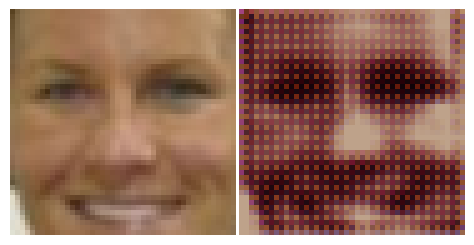

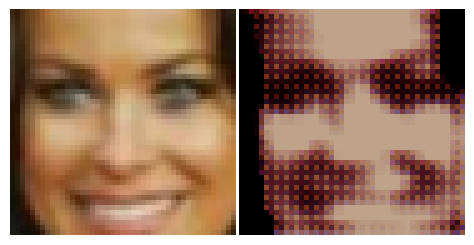

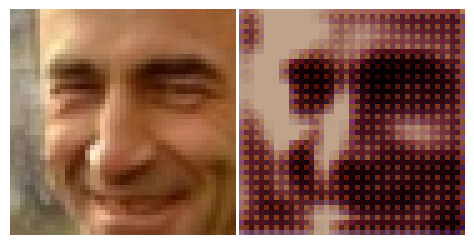

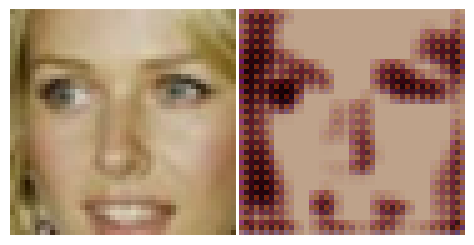

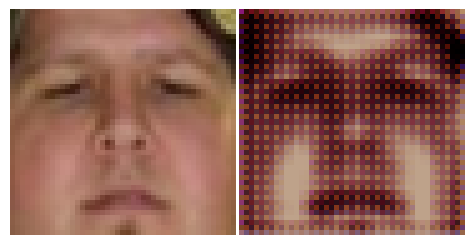

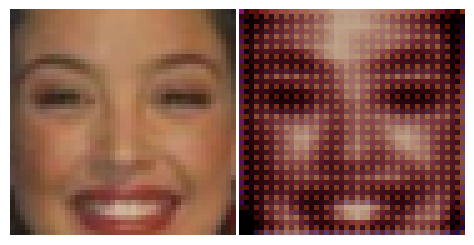

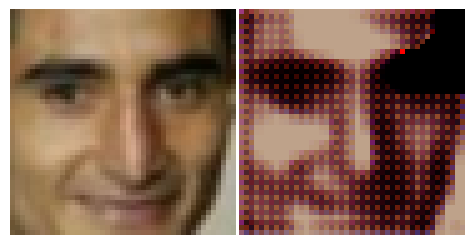

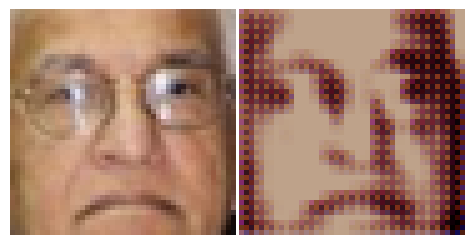

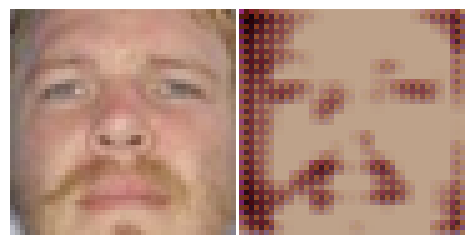

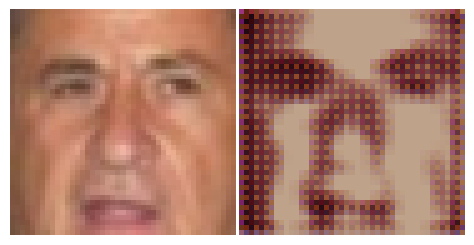

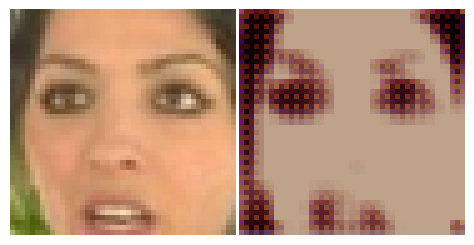

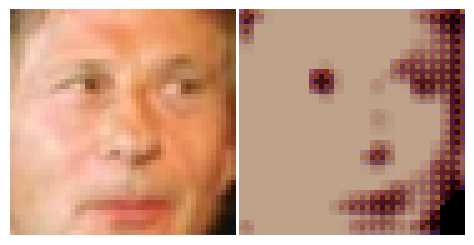

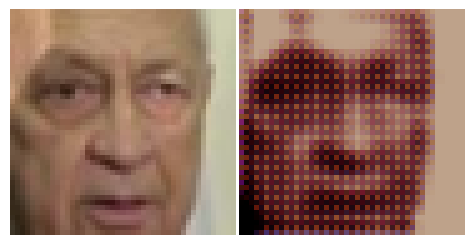

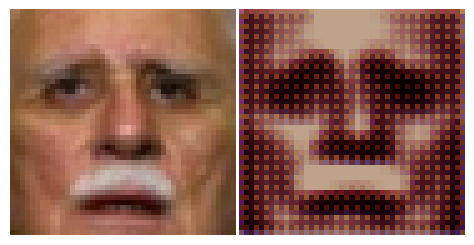

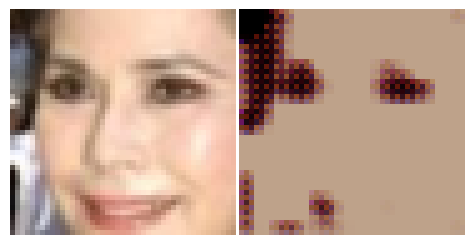

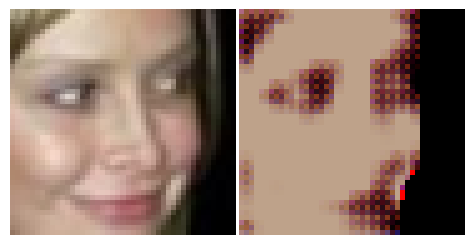

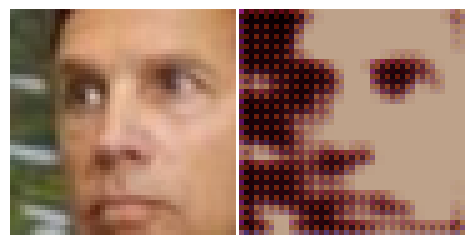

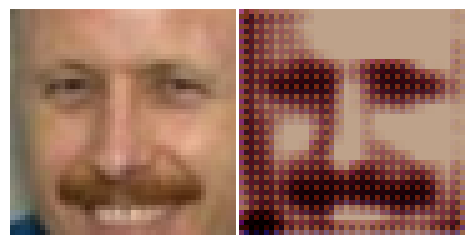

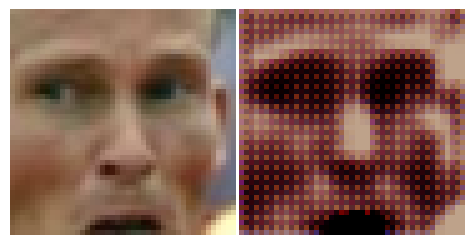

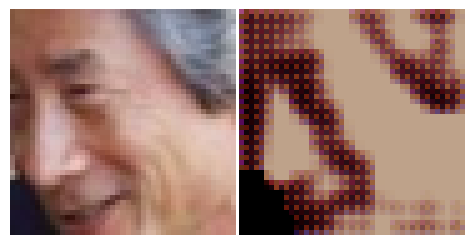

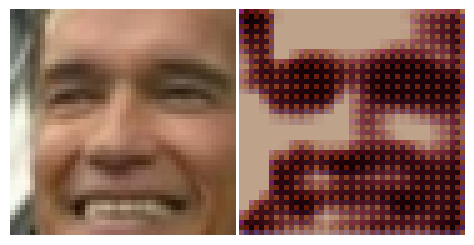

EPOCH: 40 | PHASE: TRAIN | LOSS: 0.024094286773886


100%|██████████| 83/83 [00:00<00:00, 124.01it/s]


EPOCH: 41 | PHASE: TRAIN | LOSS: 0.026105789063745236
EPOCH: 41 | PHASE: TRAIN | LOSS: 0.027562511641354787


100%|██████████| 83/83 [00:00<00:00, 128.33it/s]


EPOCH: 42 | PHASE: TRAIN | LOSS: 0.022658375394811112
EPOCH: 42 | PHASE: TRAIN | LOSS: 0.018484150015172503


100%|██████████| 83/83 [00:00<00:00, 128.35it/s]


EPOCH: 43 | PHASE: TRAIN | LOSS: 0.014640572121793247
EPOCH: 43 | PHASE: TRAIN | LOSS: 0.013922601406063353


100%|██████████| 83/83 [00:00<00:00, 128.32it/s]


EPOCH: 44 | PHASE: TRAIN | LOSS: 0.01667175026812467
EPOCH: 44 | PHASE: TRAIN | LOSS: 0.019993961123483523


100%|██████████| 83/83 [00:00<00:00, 126.16it/s]

EPOCH: 45 | PHASE: TRAIN | LOSS: 0.023358617314552688


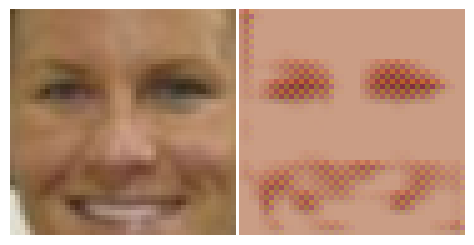

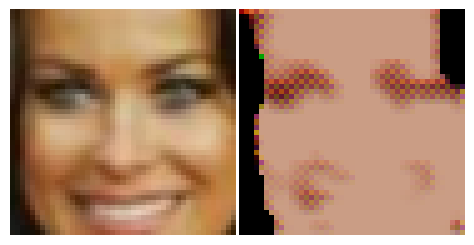

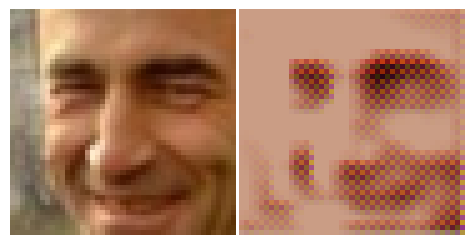

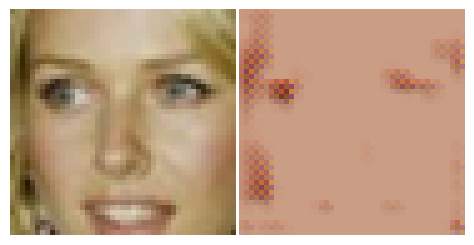

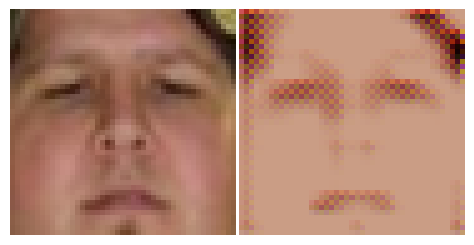

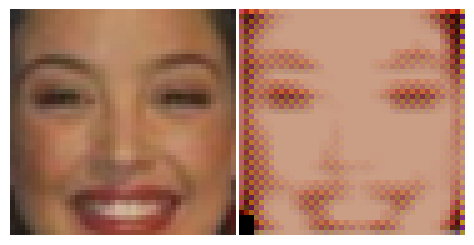

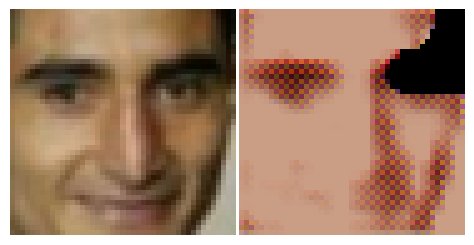

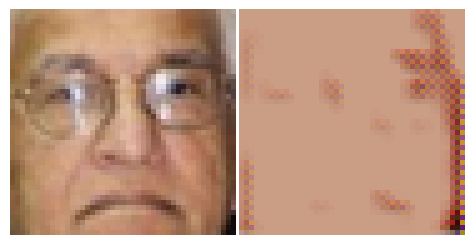

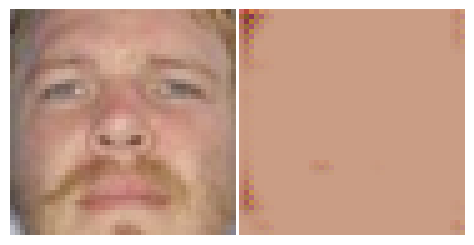

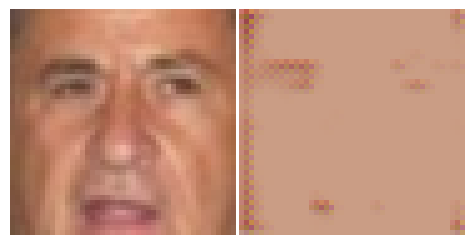

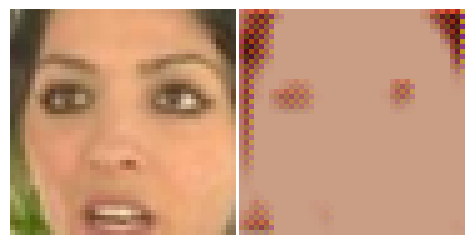

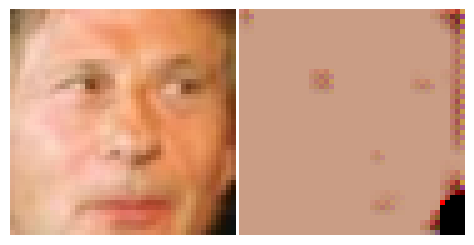

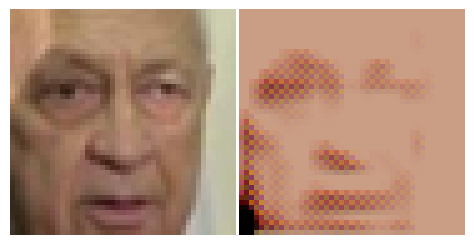

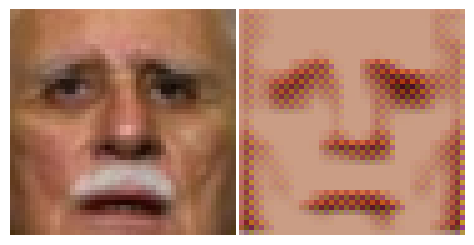

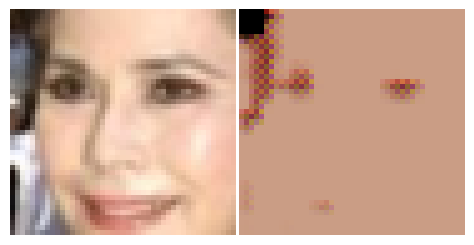

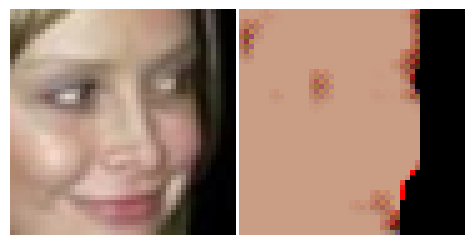

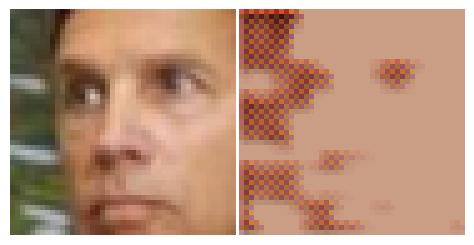

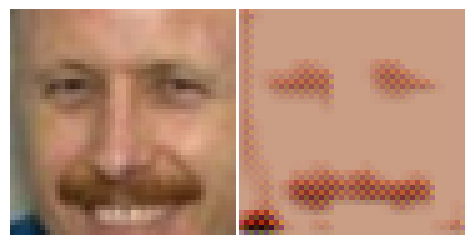

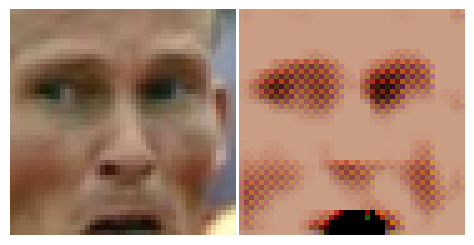

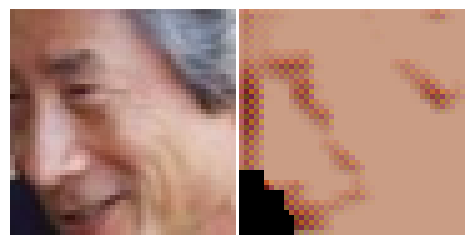

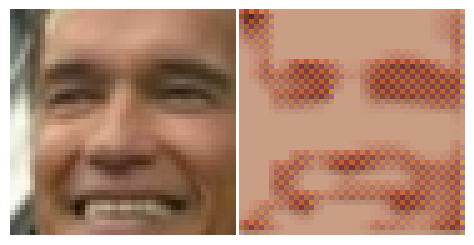

EPOCH: 45 | PHASE: TRAIN | LOSS: 0.02487127340975262


100%|██████████| 83/83 [00:00<00:00, 125.10it/s]


EPOCH: 46 | PHASE: TRAIN | LOSS: 0.024926486077258385
EPOCH: 46 | PHASE: TRAIN | LOSS: 0.023211889501128877


100%|██████████| 83/83 [00:00<00:00, 124.62it/s]


EPOCH: 47 | PHASE: TRAIN | LOSS: 0.020895316411393236
EPOCH: 47 | PHASE: TRAIN | LOSS: 0.018167623629172642


100%|██████████| 83/83 [00:00<00:00, 125.95it/s]


EPOCH: 48 | PHASE: TRAIN | LOSS: 0.0164415358554527
EPOCH: 48 | PHASE: TRAIN | LOSS: 0.016122801850239437


100%|██████████| 83/83 [00:00<00:00, 126.63it/s]


EPOCH: 49 | PHASE: TRAIN | LOSS: 0.01737064391329705
EPOCH: 49 | PHASE: TRAIN | LOSS: 0.020840451830909365


100%|██████████| 83/83 [00:00<00:00, 127.38it/s]

EPOCH: 50 | PHASE: TRAIN | LOSS: 0.02334872038518808


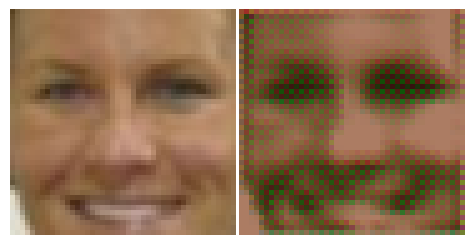

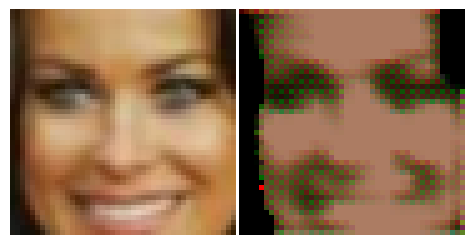

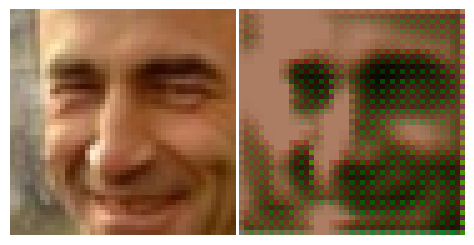

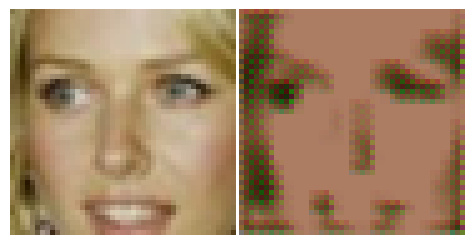

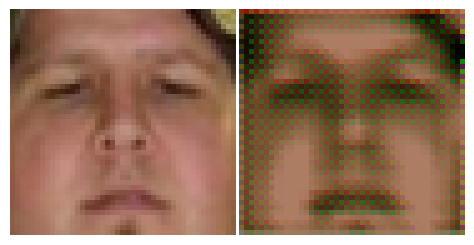

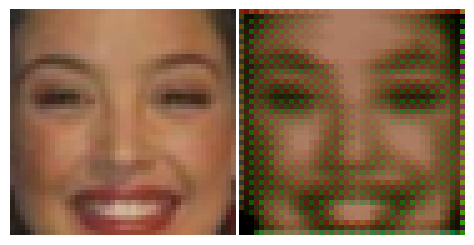

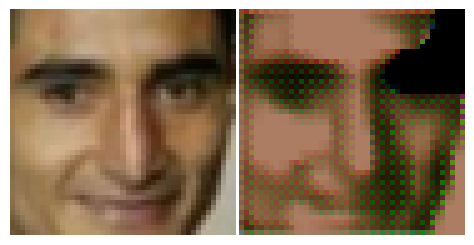

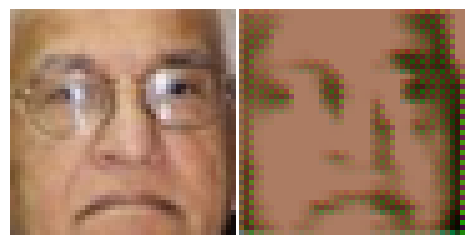

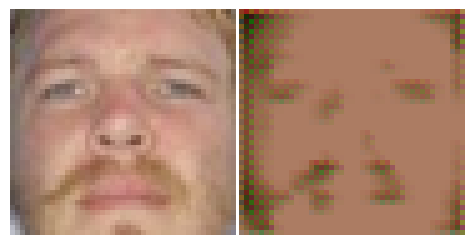

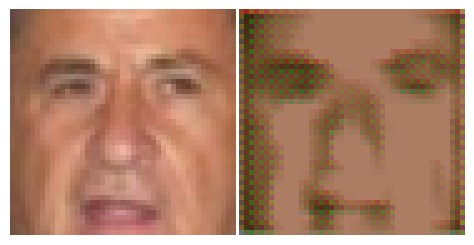

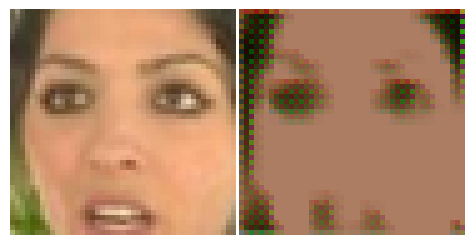

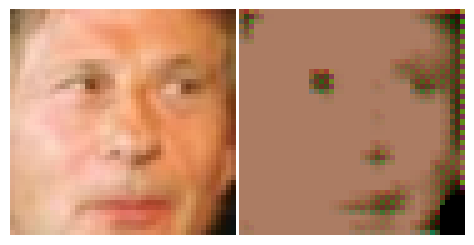

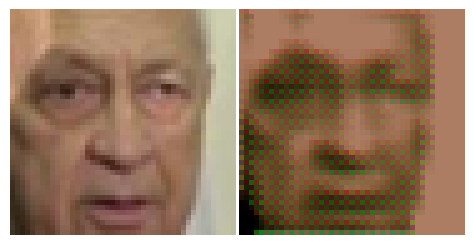

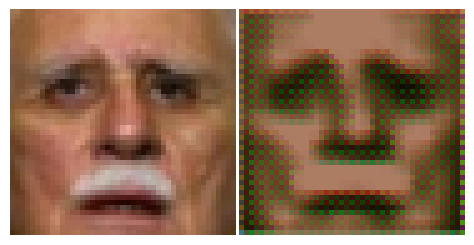

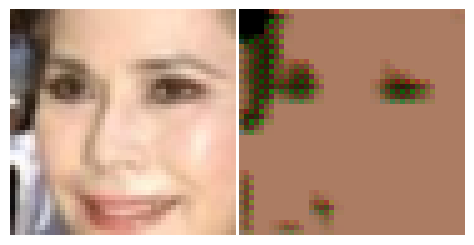

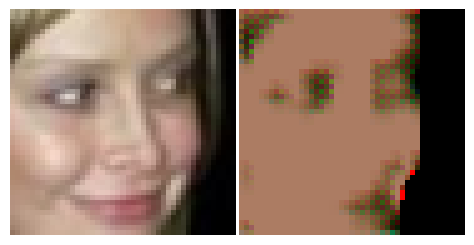

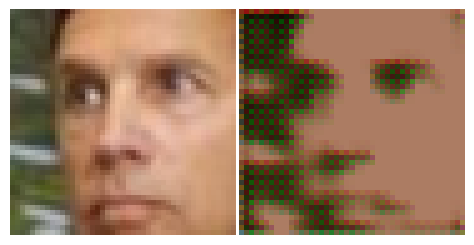

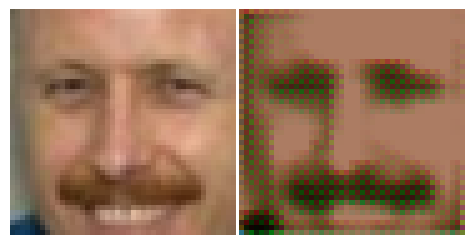

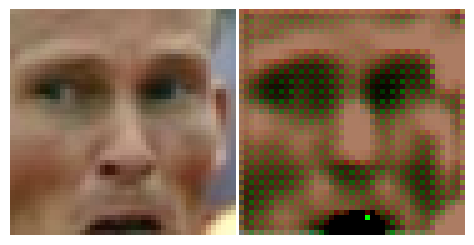

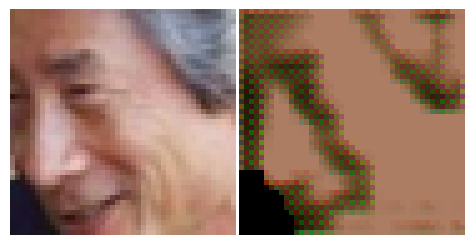

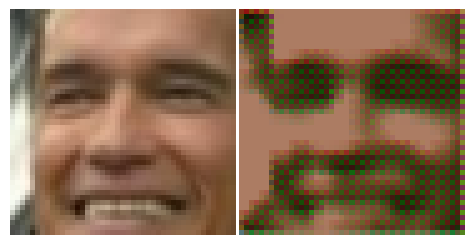

EPOCH: 50 | PHASE: TRAIN | LOSS: 0.027096121971096312


100%|██████████| 83/83 [00:00<00:00, 127.60it/s]


EPOCH: 51 | PHASE: TRAIN | LOSS: 0.02663034519337746
EPOCH: 51 | PHASE: TRAIN | LOSS: 0.026542662953337032


100%|██████████| 83/83 [00:00<00:00, 128.00it/s]


EPOCH: 52 | PHASE: TRAIN | LOSS: 0.02244123129780034
EPOCH: 52 | PHASE: TRAIN | LOSS: 0.019522054209595636


100%|██████████| 83/83 [00:00<00:00, 131.22it/s]


EPOCH: 53 | PHASE: TRAIN | LOSS: 0.01655300472111228
EPOCH: 53 | PHASE: TRAIN | LOSS: 0.015761202556036767


100%|██████████| 83/83 [00:00<00:00, 131.59it/s]


EPOCH: 54 | PHASE: TRAIN | LOSS: 0.017061981484742767
EPOCH: 54 | PHASE: TRAIN | LOSS: 0.019343366314257895


100%|██████████| 83/83 [00:00<00:00, 132.09it/s]

EPOCH: 55 | PHASE: TRAIN | LOSS: 0.022389828507979232


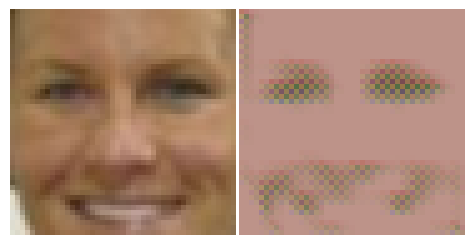

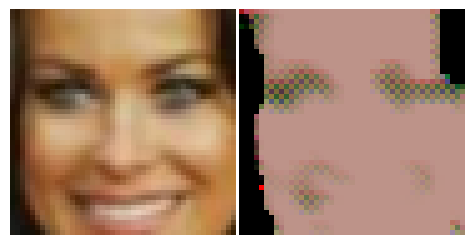

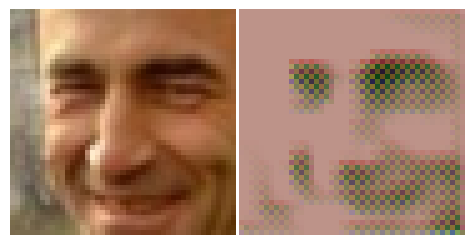

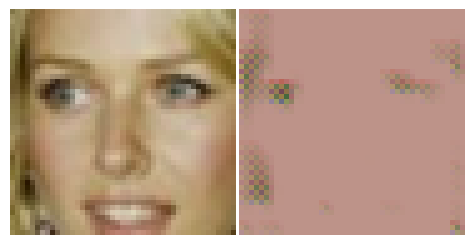

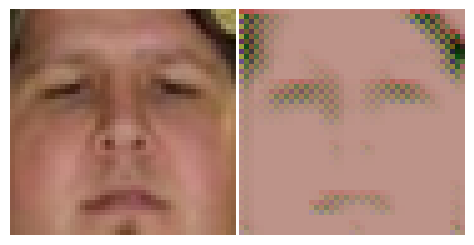

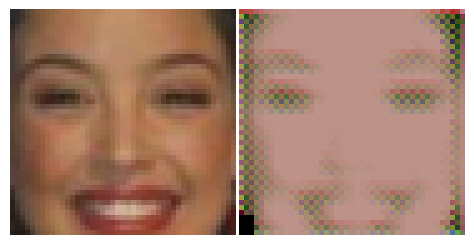

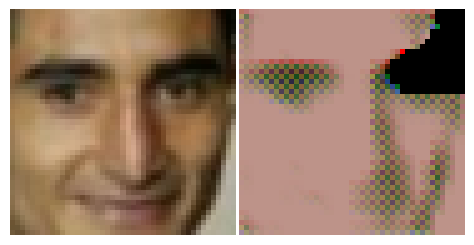

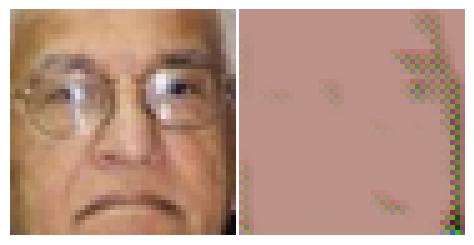

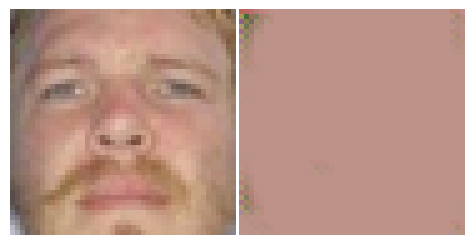

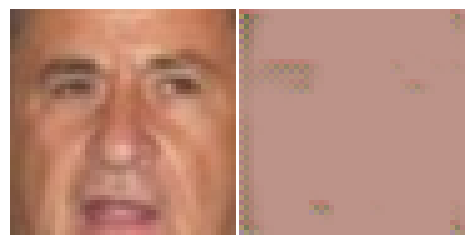

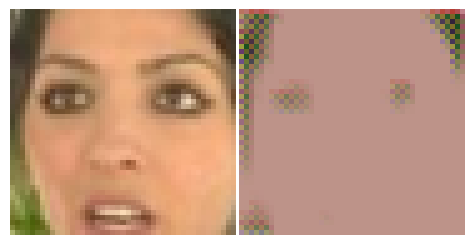

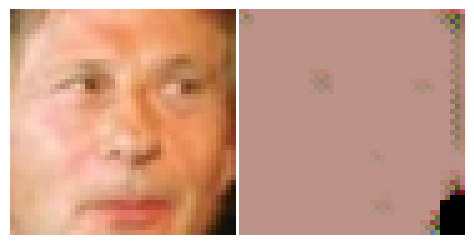

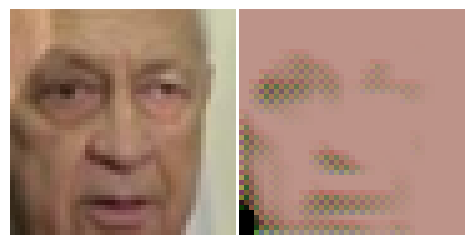

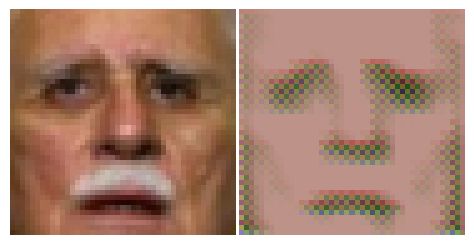

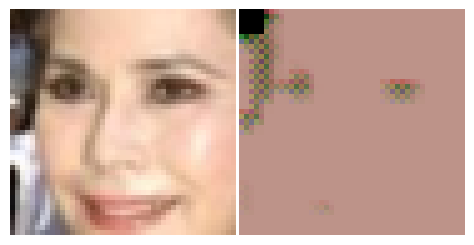

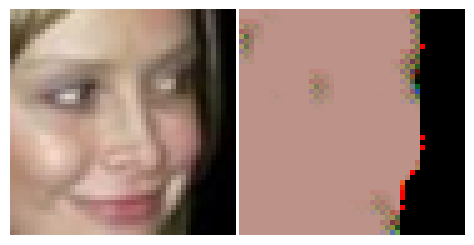

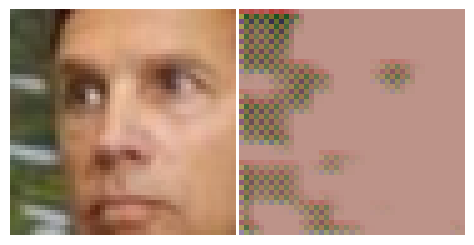

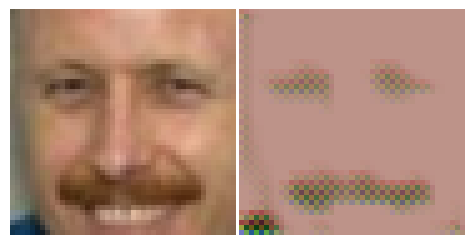

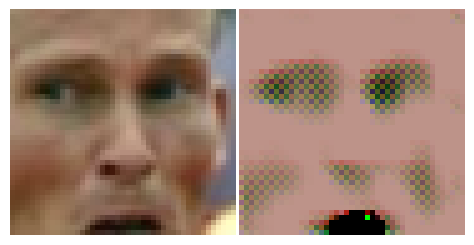

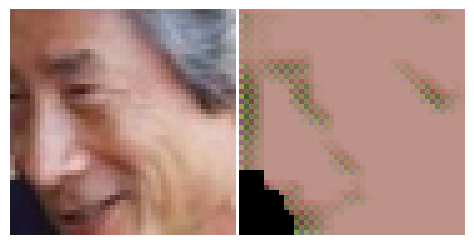

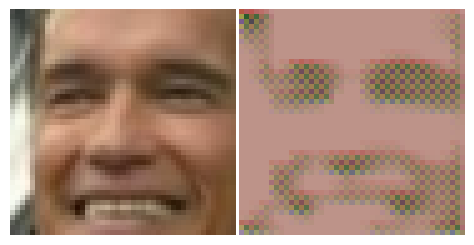

EPOCH: 55 | PHASE: TRAIN | LOSS: 0.02475438391168912


100%|██████████| 83/83 [00:00<00:00, 129.65it/s]


EPOCH: 56 | PHASE: TRAIN | LOSS: 0.02646398528602468
EPOCH: 56 | PHASE: TRAIN | LOSS: 0.026597161378179277


100%|██████████| 83/83 [00:00<00:00, 130.09it/s]


EPOCH: 57 | PHASE: TRAIN | LOSS: 0.02551744247685714
EPOCH: 57 | PHASE: TRAIN | LOSS: 0.022797395342162678


100%|██████████| 83/83 [00:00<00:00, 127.86it/s]


EPOCH: 58 | PHASE: TRAIN | LOSS: 0.019684325409940927
EPOCH: 58 | PHASE: TRAIN | LOSS: 0.016370379720770177


100%|██████████| 83/83 [00:00<00:00, 127.01it/s]


EPOCH: 59 | PHASE: TRAIN | LOSS: 0.014961311548768756
EPOCH: 59 | PHASE: TRAIN | LOSS: 0.015509712332416149


100%|██████████| 83/83 [00:00<00:00, 128.88it/s]

EPOCH: 60 | PHASE: TRAIN | LOSS: 0.01795358902000519


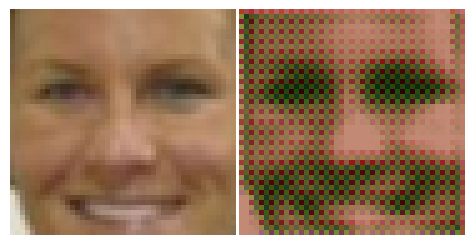

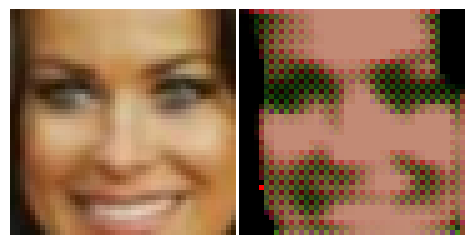

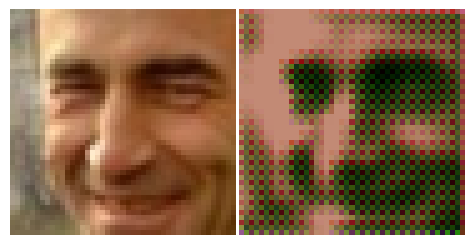

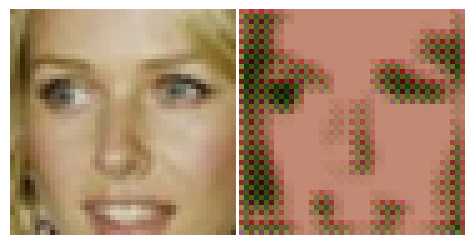

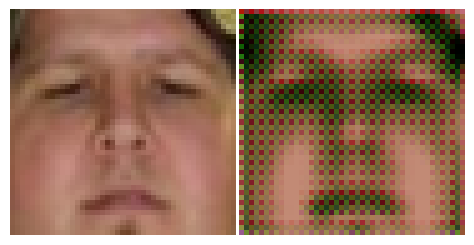

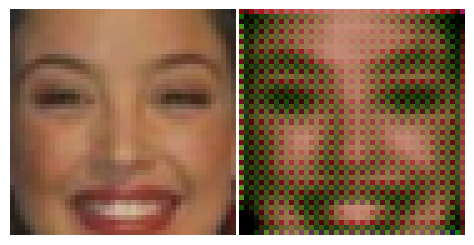

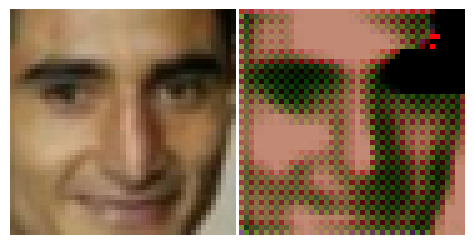

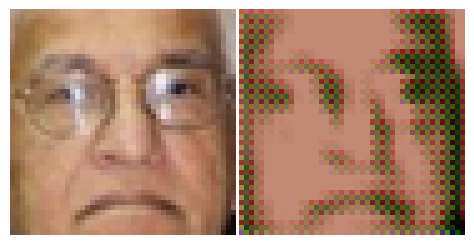

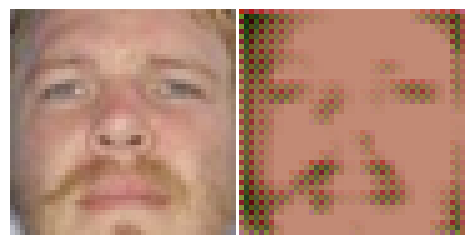

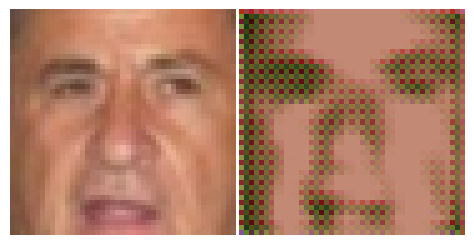

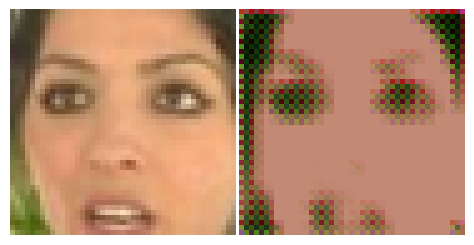

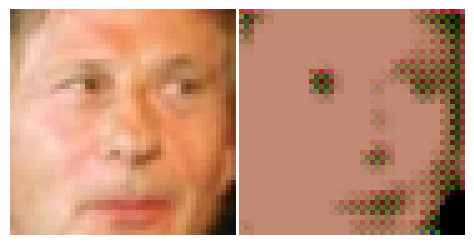

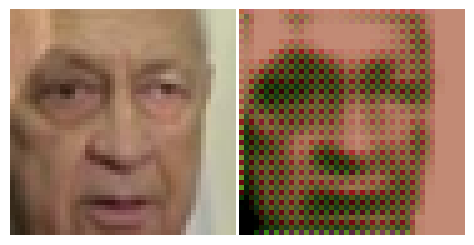

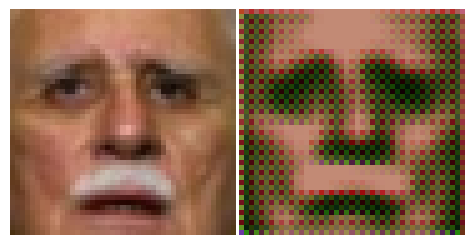

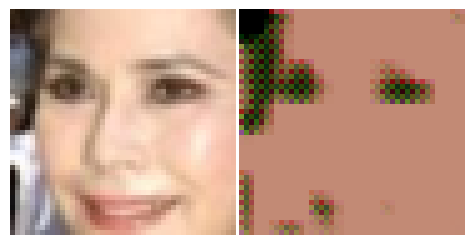

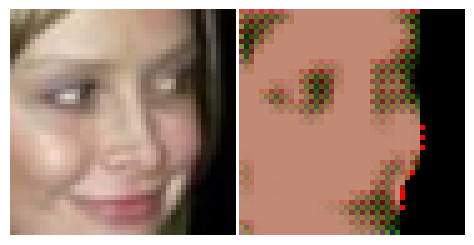

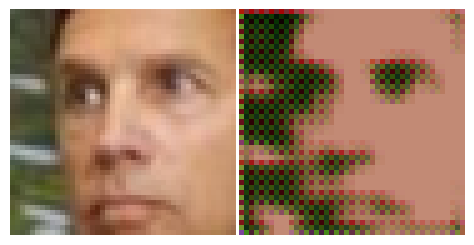

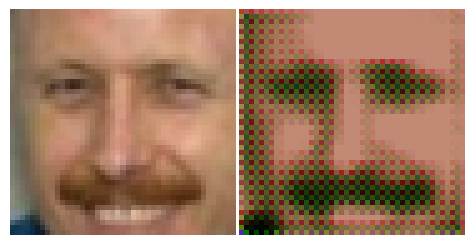

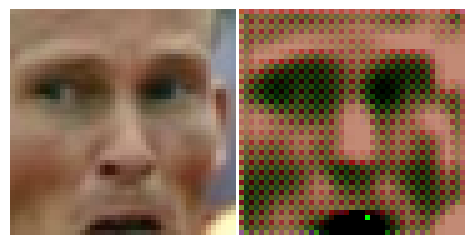

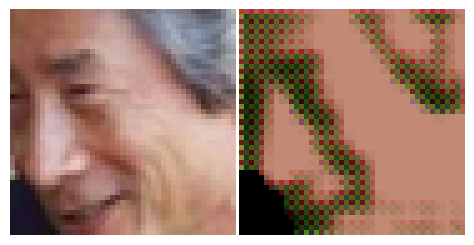

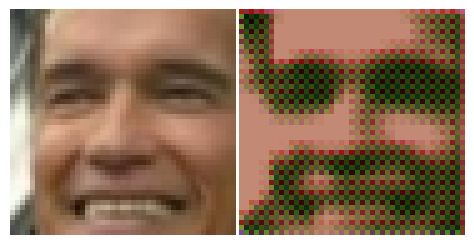

EPOCH: 60 | PHASE: TRAIN | LOSS: 0.022429635748267174


100%|██████████| 83/83 [00:00<00:00, 126.08it/s]


EPOCH: 61 | PHASE: TRAIN | LOSS: 0.024902416236070264
EPOCH: 61 | PHASE: TRAIN | LOSS: 0.02786406147338095


100%|██████████| 83/83 [00:00<00:00, 127.02it/s]


EPOCH: 62 | PHASE: TRAIN | LOSS: 0.02584545749677233
EPOCH: 62 | PHASE: TRAIN | LOSS: 0.024057575191060703


100%|██████████| 83/83 [00:00<00:00, 127.92it/s]


EPOCH: 63 | PHASE: TRAIN | LOSS: 0.019394431869129102
EPOCH: 63 | PHASE: TRAIN | LOSS: 0.016601460231911568


100%|██████████| 83/83 [00:00<00:00, 127.60it/s]


EPOCH: 64 | PHASE: TRAIN | LOSS: 0.015003642359052796
EPOCH: 64 | PHASE: TRAIN | LOSS: 0.015620083681174688


100%|██████████| 83/83 [00:00<00:00, 128.74it/s]

EPOCH: 65 | PHASE: TRAIN | LOSS: 0.018141805272863572


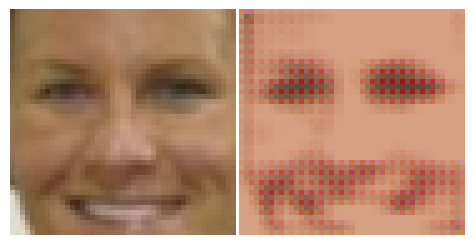

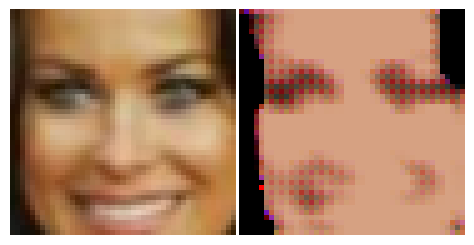

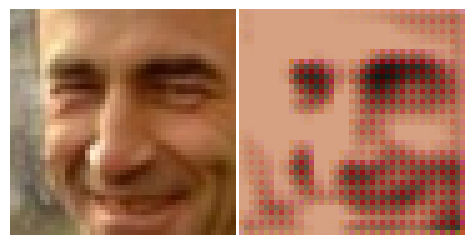

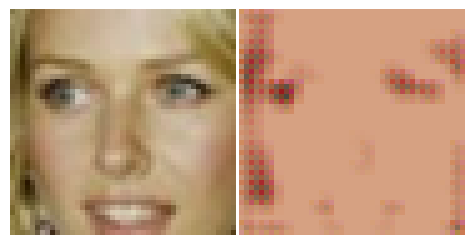

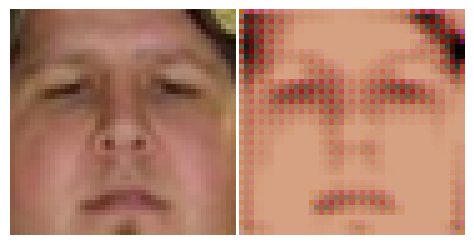

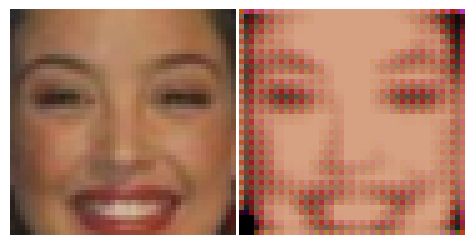

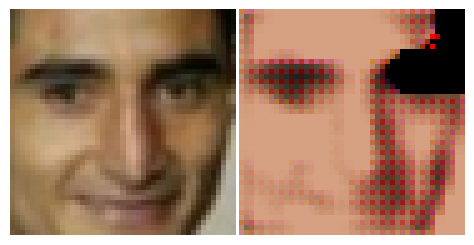

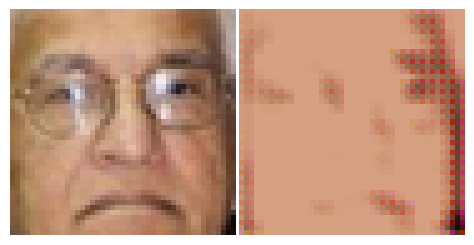

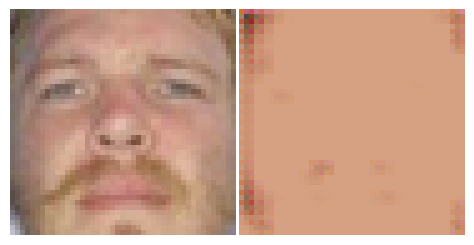

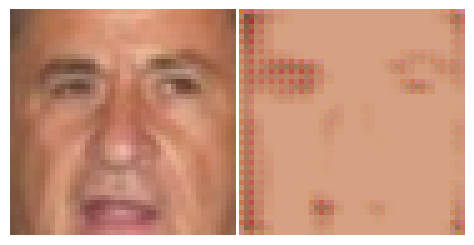

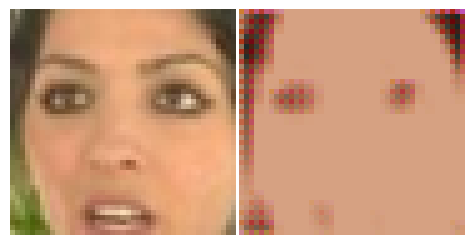

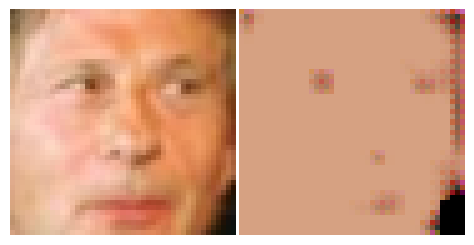

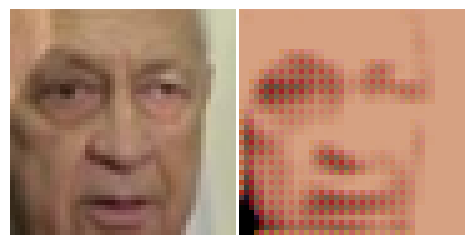

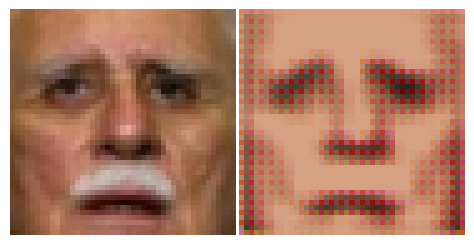

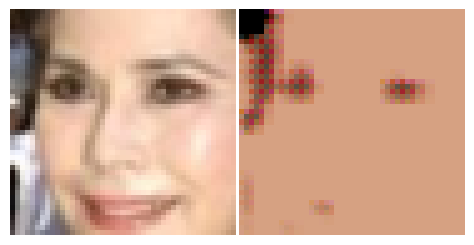

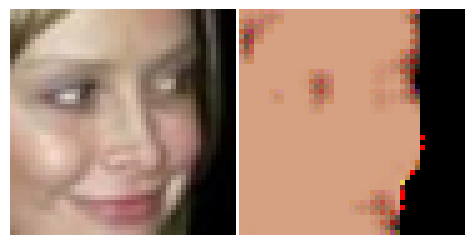

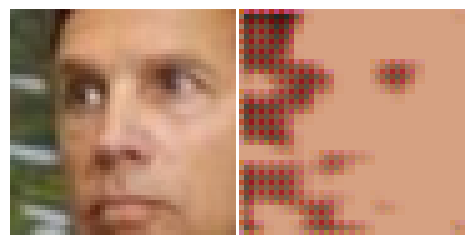

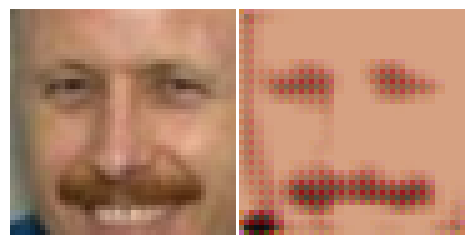

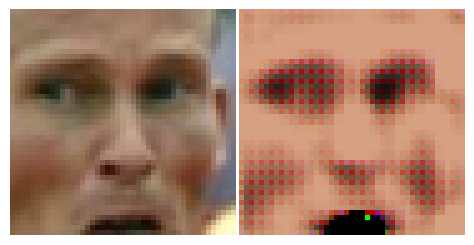

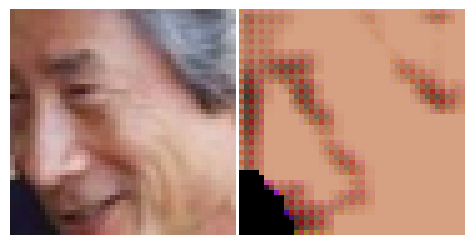

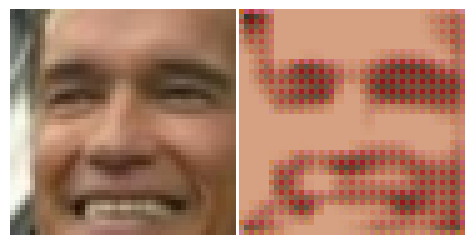

EPOCH: 65 | PHASE: TRAIN | LOSS: 0.02107493801131135


100%|██████████| 83/83 [00:00<00:00, 127.94it/s]


EPOCH: 66 | PHASE: TRAIN | LOSS: 0.024163141689566243
EPOCH: 66 | PHASE: TRAIN | LOSS: 0.025739949640064014


100%|██████████| 83/83 [00:00<00:00, 127.53it/s]


EPOCH: 67 | PHASE: TRAIN | LOSS: 0.02600611041647842
EPOCH: 67 | PHASE: TRAIN | LOSS: 0.023917144164443016


100%|██████████| 83/83 [00:00<00:00, 129.83it/s]


EPOCH: 68 | PHASE: TRAIN | LOSS: 0.02079953349767679
EPOCH: 68 | PHASE: TRAIN | LOSS: 0.016516497536074547


100%|██████████| 83/83 [00:00<00:00, 129.39it/s]


EPOCH: 69 | PHASE: TRAIN | LOSS: 0.014210359462682742
EPOCH: 69 | PHASE: TRAIN | LOSS: 0.013718611427715846


100%|██████████| 83/83 [00:00<00:00, 130.66it/s]

EPOCH: 70 | PHASE: TRAIN | LOSS: 0.016278001266610193


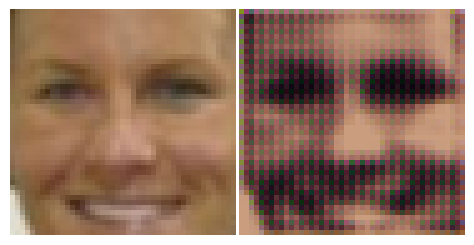

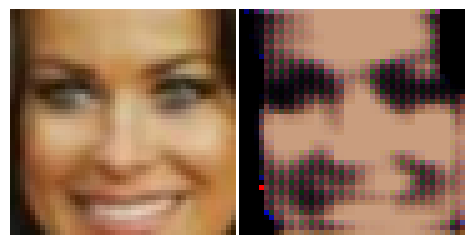

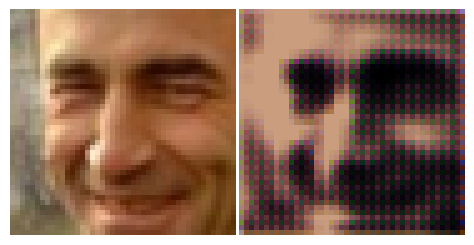

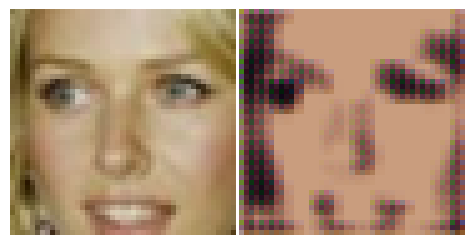

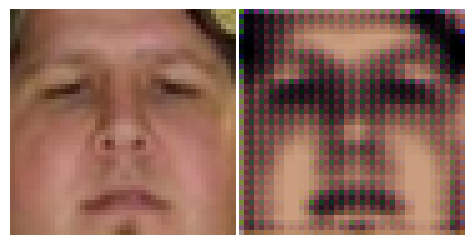

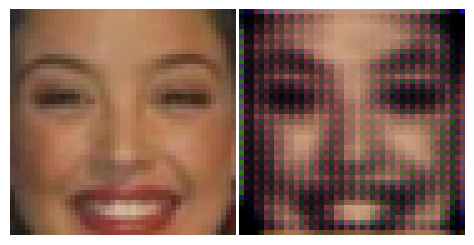

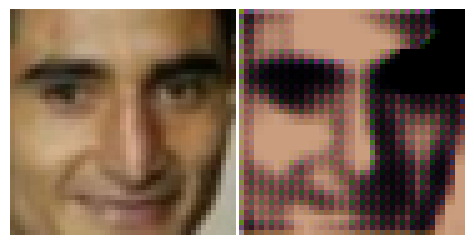

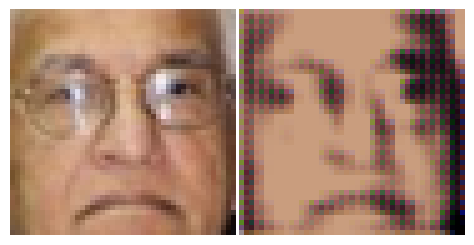

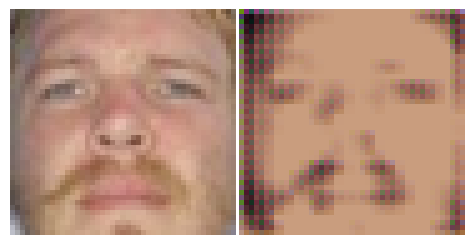

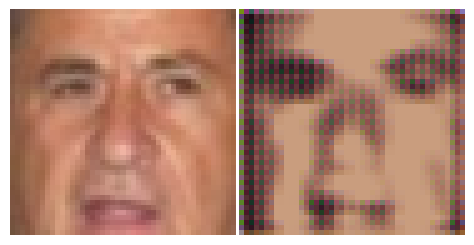

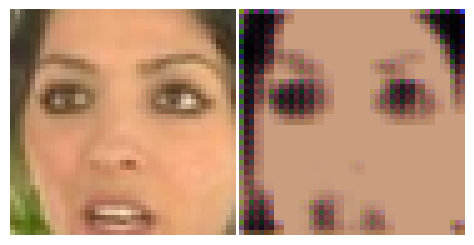

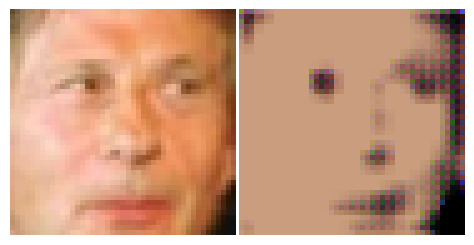

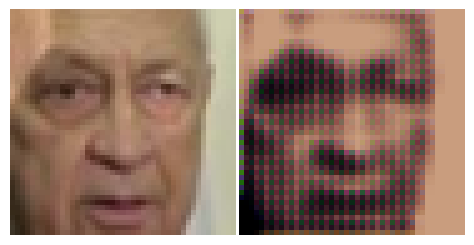

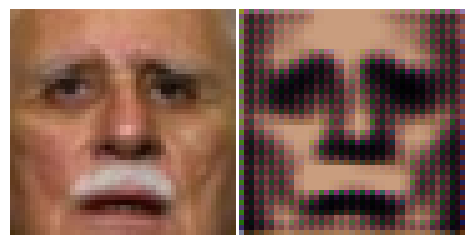

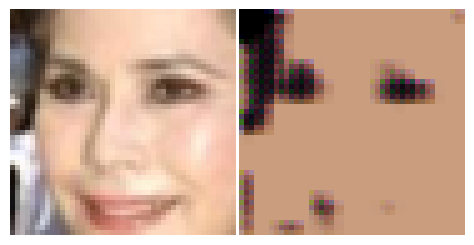

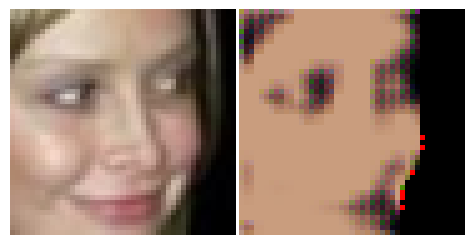

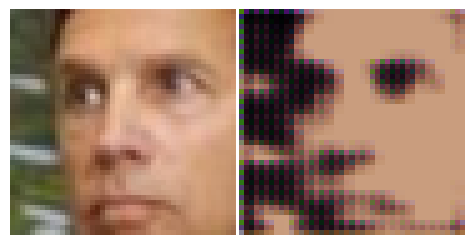

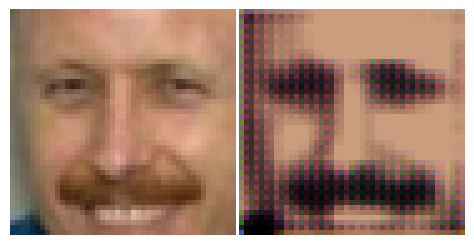

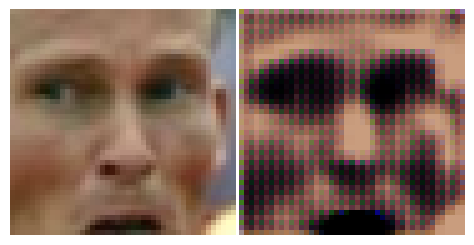

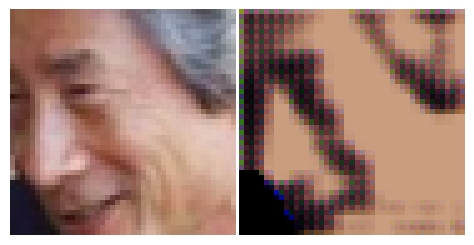

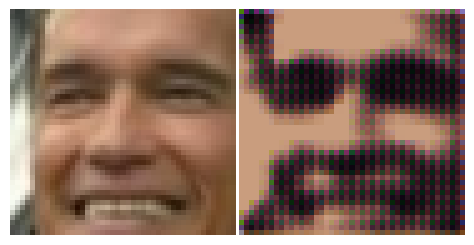

EPOCH: 70 | PHASE: TRAIN | LOSS: 0.021154177508183887


100%|██████████| 83/83 [00:00<00:00, 126.99it/s]


EPOCH: 71 | PHASE: TRAIN | LOSS: 0.024772164984101272
EPOCH: 71 | PHASE: TRAIN | LOSS: 0.028872223837035044


100%|██████████| 83/83 [00:00<00:00, 128.66it/s]


EPOCH: 72 | PHASE: TRAIN | LOSS: 0.02792232532996729
EPOCH: 72 | PHASE: TRAIN | LOSS: 0.026678751178440593


100%|██████████| 83/83 [00:00<00:00, 125.36it/s]


EPOCH: 73 | PHASE: TRAIN | LOSS: 0.021712104083005203
EPOCH: 73 | PHASE: TRAIN | LOSS: 0.018108039296099117


100%|██████████| 83/83 [00:00<00:00, 127.57it/s]


EPOCH: 74 | PHASE: TRAIN | LOSS: 0.01554929735475635
EPOCH: 74 | PHASE: TRAIN | LOSS: 0.015369284898042679


100%|██████████| 83/83 [00:00<00:00, 129.13it/s]

EPOCH: 75 | PHASE: TRAIN | LOSS: 0.01746281842330852


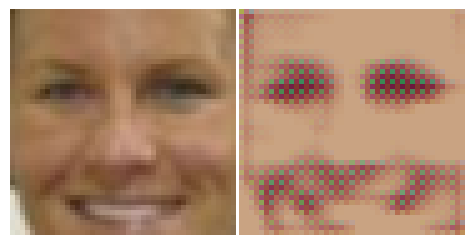

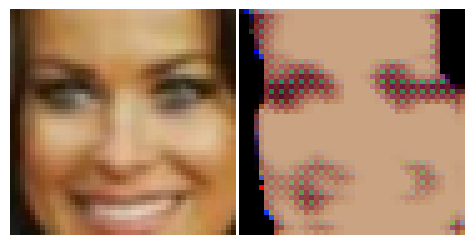

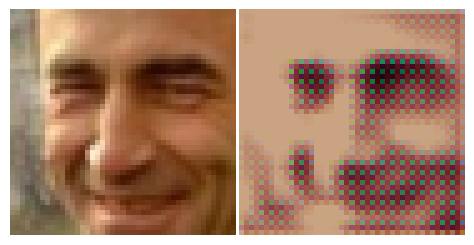

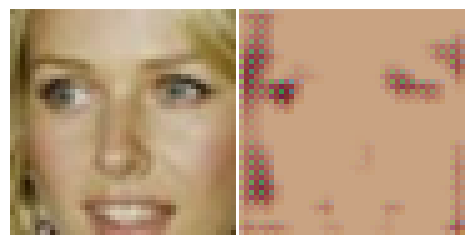

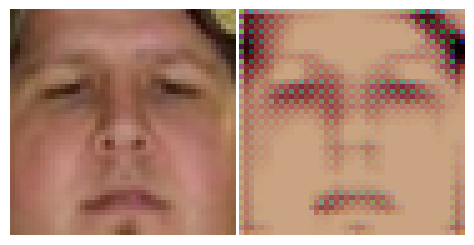

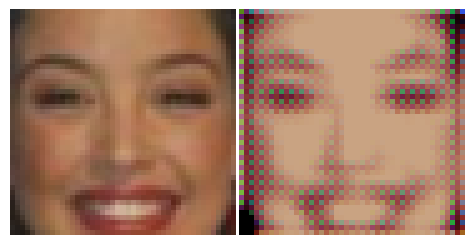

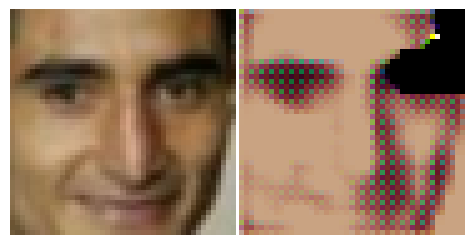

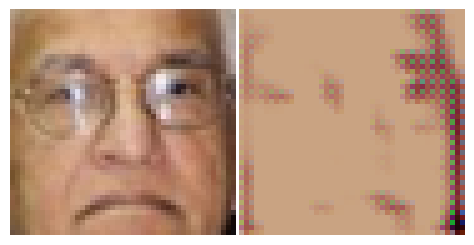

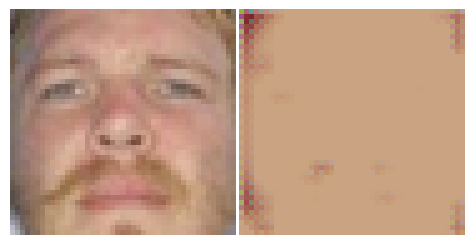

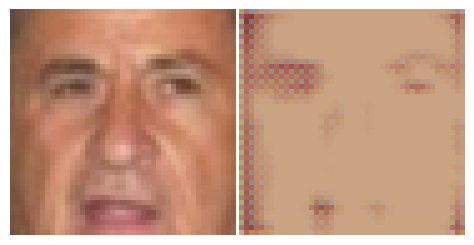

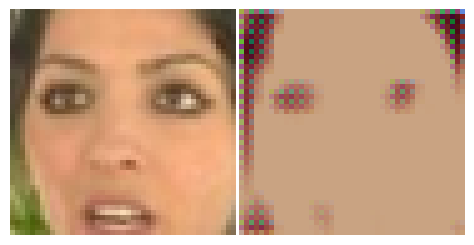

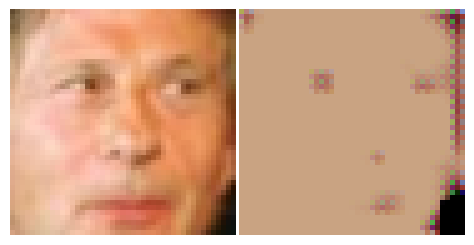

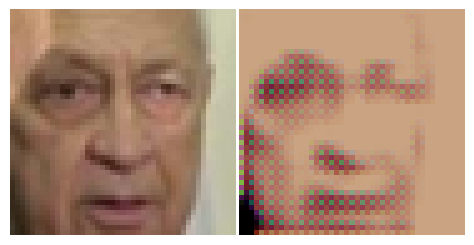

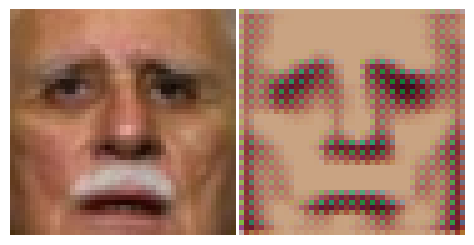

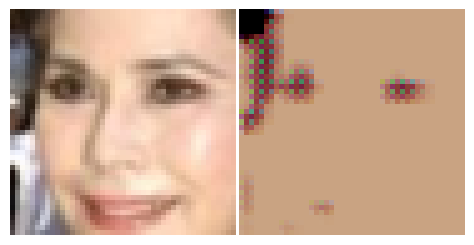

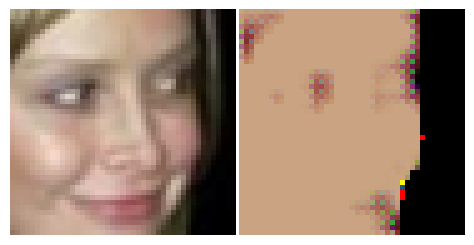

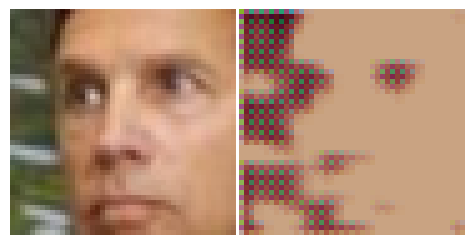

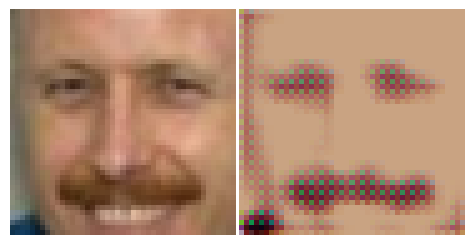

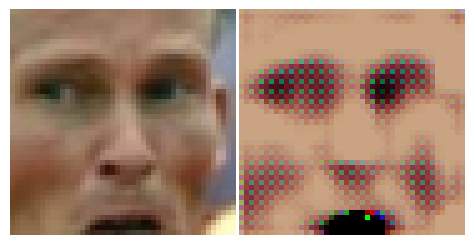

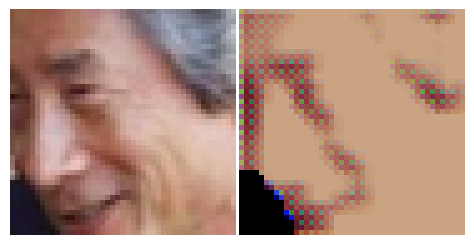

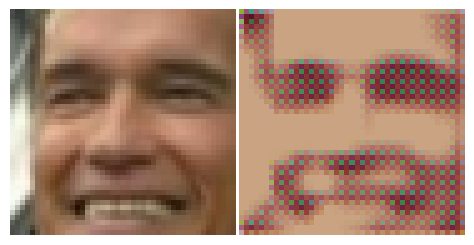

EPOCH: 75 | PHASE: TRAIN | LOSS: 0.020208211704379038


100%|██████████| 83/83 [00:00<00:00, 127.50it/s]


EPOCH: 76 | PHASE: TRAIN | LOSS: 0.023167921028223383
EPOCH: 76 | PHASE: TRAIN | LOSS: 0.024963634709517162


100%|██████████| 83/83 [00:00<00:00, 128.16it/s]


EPOCH: 77 | PHASE: TRAIN | LOSS: 0.025682650349405874
EPOCH: 77 | PHASE: TRAIN | LOSS: 0.024878081022983507


100%|██████████| 83/83 [00:00<00:00, 124.77it/s]


EPOCH: 78 | PHASE: TRAIN | LOSS: 0.023338881444679684
EPOCH: 78 | PHASE: TRAIN | LOSS: 0.0210795703211001


100%|██████████| 83/83 [00:00<00:00, 128.43it/s]


EPOCH: 79 | PHASE: TRAIN | LOSS: 0.019118163532700884
EPOCH: 79 | PHASE: TRAIN | LOSS: 0.01763541056286721


100%|██████████| 83/83 [00:00<00:00, 127.49it/s]

EPOCH: 80 | PHASE: TRAIN | LOSS: 0.017004315270088523


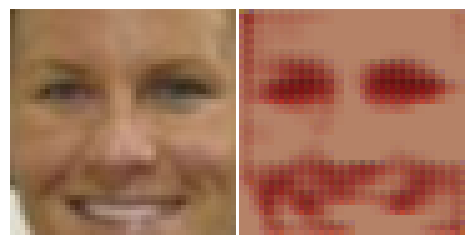

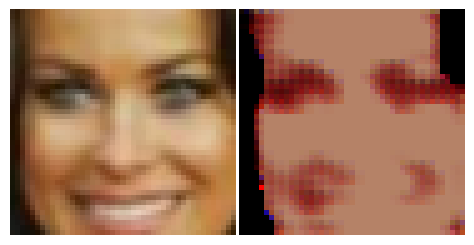

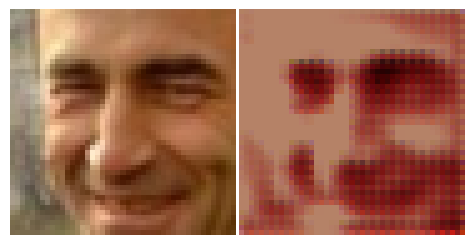

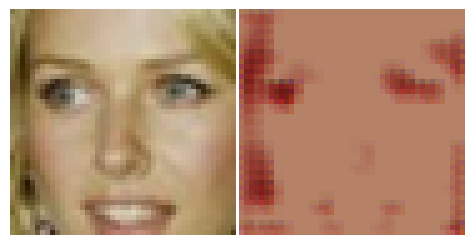

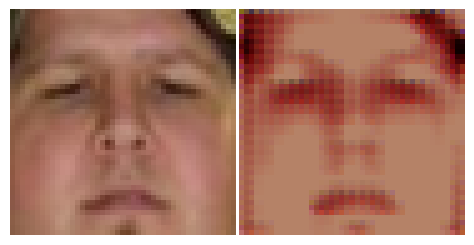

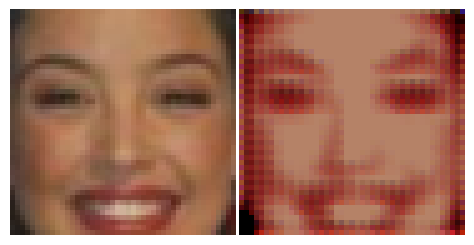

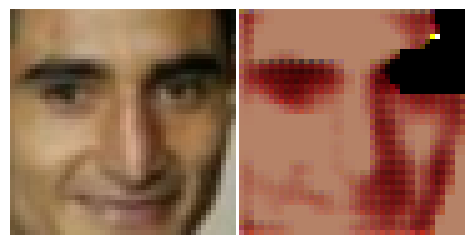

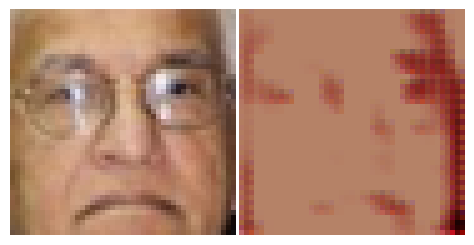

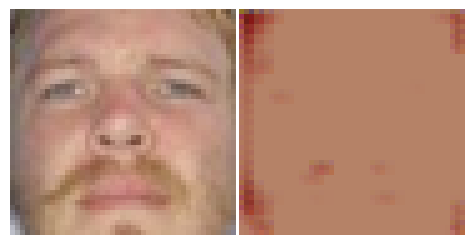

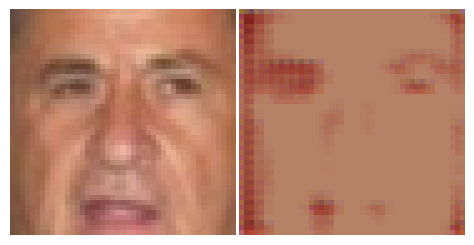

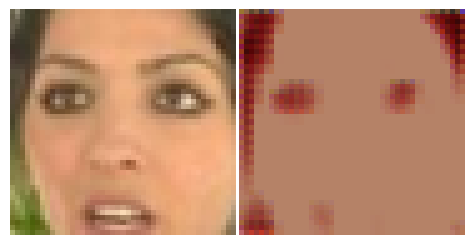

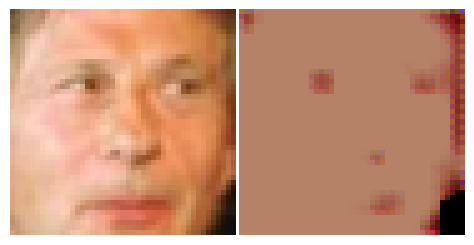

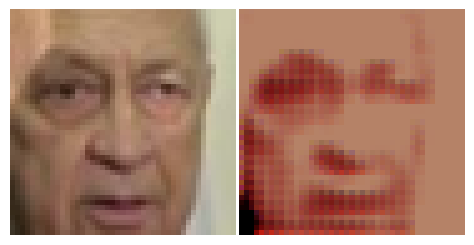

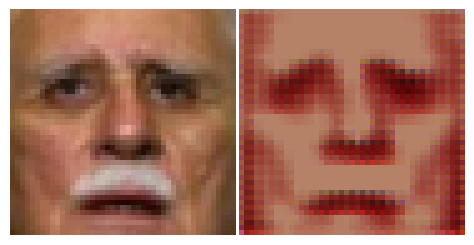

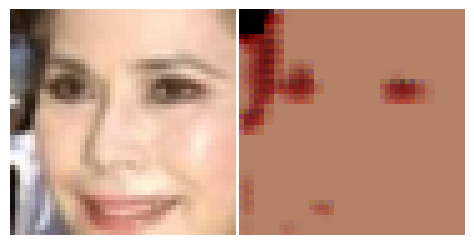

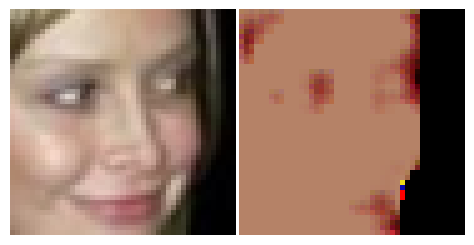

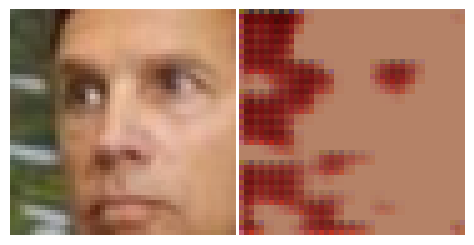

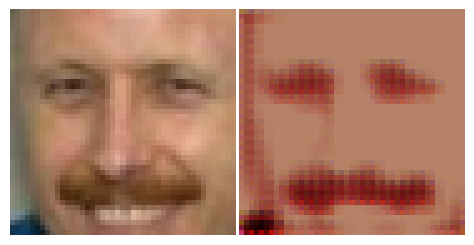

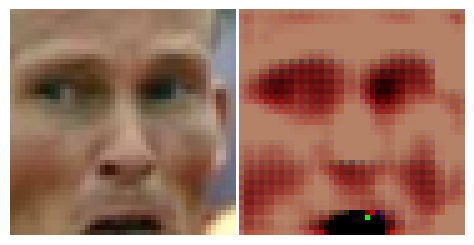

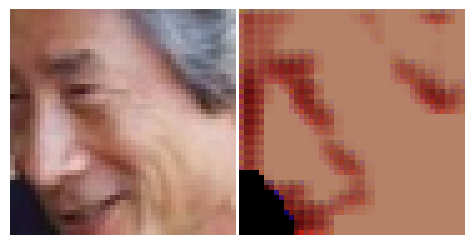

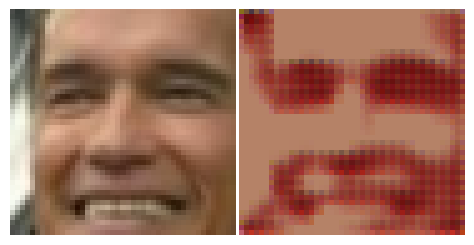

EPOCH: 80 | PHASE: TRAIN | LOSS: 0.017818760215526537


100%|██████████| 83/83 [00:00<00:00, 128.71it/s]


EPOCH: 81 | PHASE: TRAIN | LOSS: 0.018923775910074454
EPOCH: 81 | PHASE: TRAIN | LOSS: 0.02176277915991488


100%|██████████| 83/83 [00:00<00:00, 125.96it/s]


EPOCH: 82 | PHASE: TRAIN | LOSS: 0.023319529818303614
EPOCH: 82 | PHASE: TRAIN | LOSS: 0.026218268931621595


100%|██████████| 83/83 [00:00<00:00, 127.38it/s]


EPOCH: 83 | PHASE: TRAIN | LOSS: 0.02618796840669161
EPOCH: 83 | PHASE: TRAIN | LOSS: 0.026982920865217846


100%|██████████| 83/83 [00:00<00:00, 125.70it/s]


EPOCH: 84 | PHASE: TRAIN | LOSS: 0.024485846083745898
EPOCH: 84 | PHASE: TRAIN | LOSS: 0.022916918975256738


100%|██████████| 83/83 [00:00<00:00, 124.99it/s]

EPOCH: 85 | PHASE: TRAIN | LOSS: 0.01981415758919285


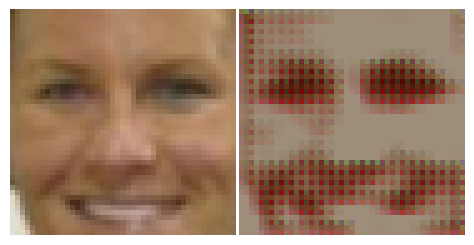

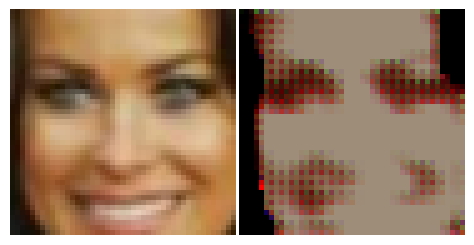

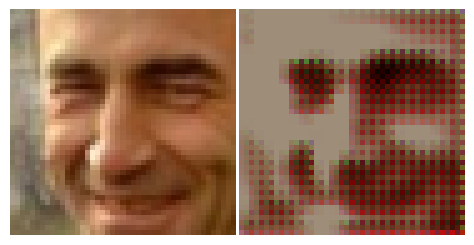

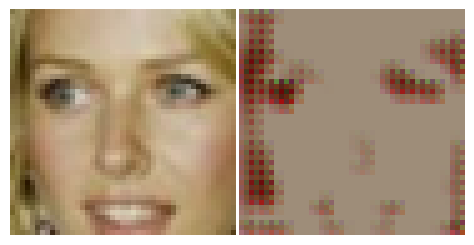

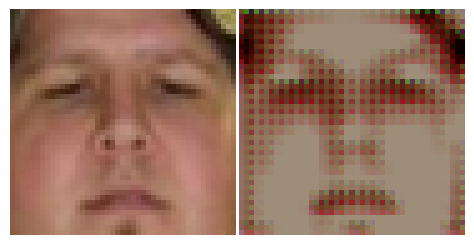

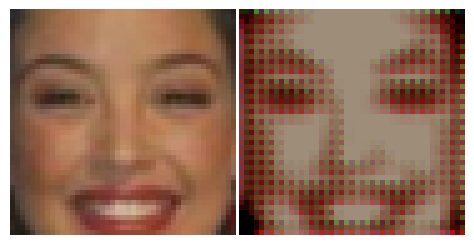

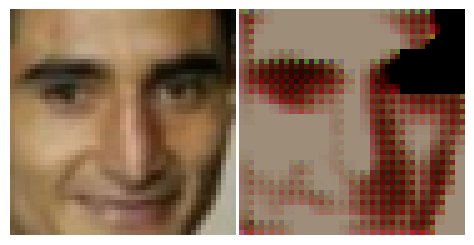

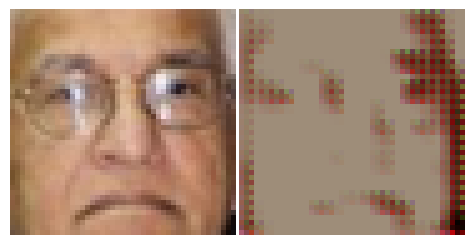

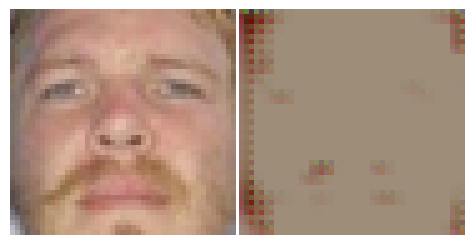

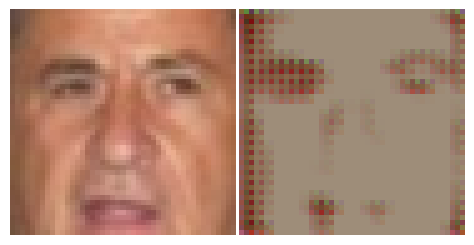

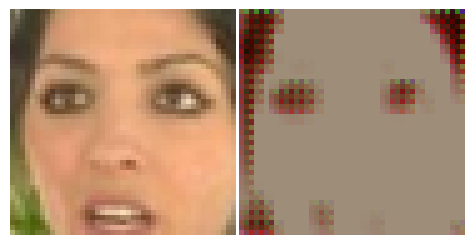

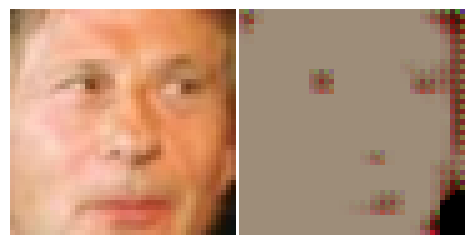

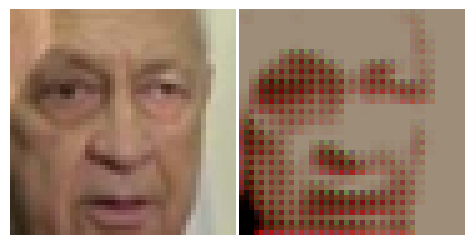

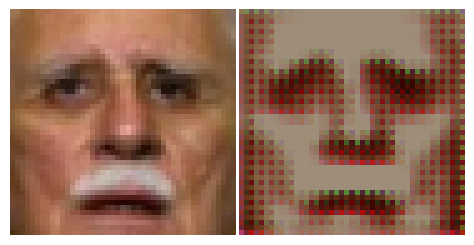

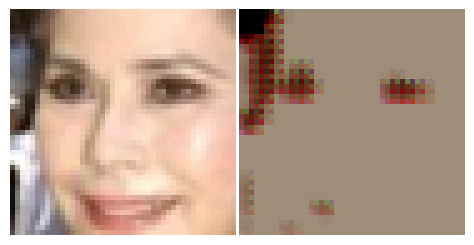

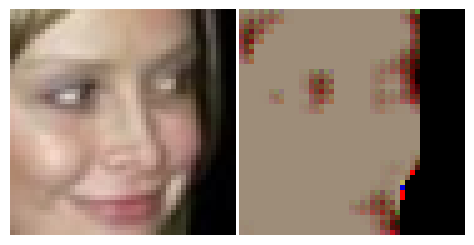

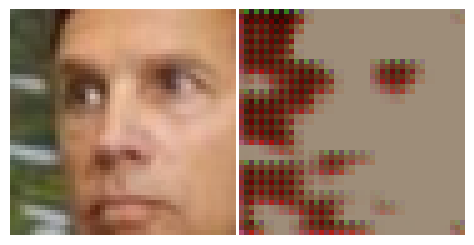

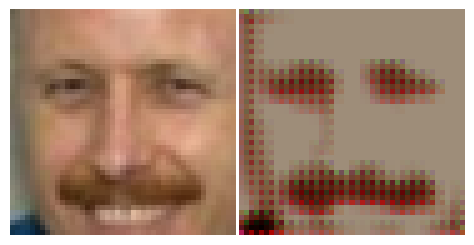

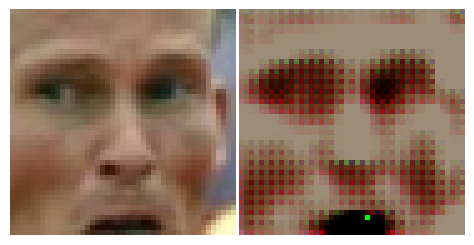

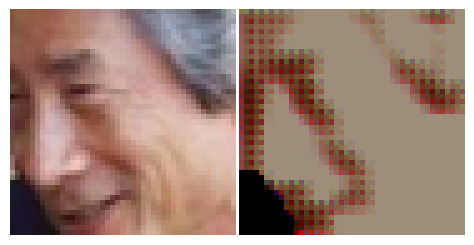

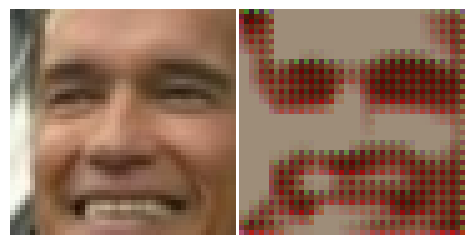

EPOCH: 85 | PHASE: TRAIN | LOSS: 0.01823772569852216


100%|██████████| 83/83 [00:00<00:00, 127.24it/s]


EPOCH: 86 | PHASE: TRAIN | LOSS: 0.017385007297418202
EPOCH: 86 | PHASE: TRAIN | LOSS: 0.01790663112132322


100%|██████████| 83/83 [00:00<00:00, 124.68it/s]


EPOCH: 87 | PHASE: TRAIN | LOSS: 0.019712031201784868
EPOCH: 87 | PHASE: TRAIN | LOSS: 0.021711608128888265


100%|██████████| 83/83 [00:00<00:00, 127.16it/s]


EPOCH: 88 | PHASE: TRAIN | LOSS: 0.024148660812930888
EPOCH: 88 | PHASE: TRAIN | LOSS: 0.02551899664103985


100%|██████████| 83/83 [00:00<00:00, 127.82it/s]


EPOCH: 89 | PHASE: TRAIN | LOSS: 0.02639258316302874
EPOCH: 89 | PHASE: TRAIN | LOSS: 0.02551552617833728


100%|██████████| 83/83 [00:00<00:00, 127.86it/s]

EPOCH: 90 | PHASE: TRAIN | LOSS: 0.023940829582602144


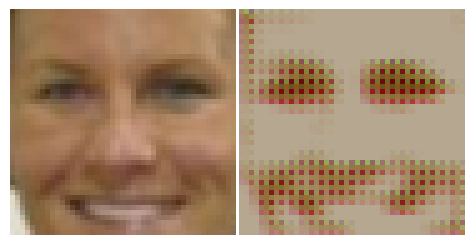

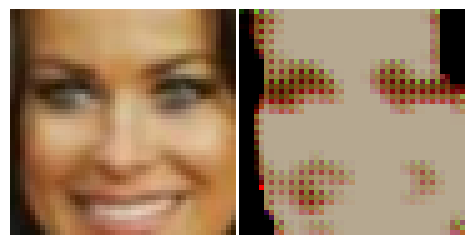

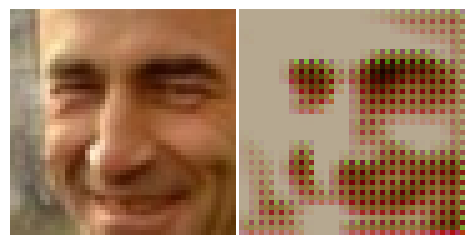

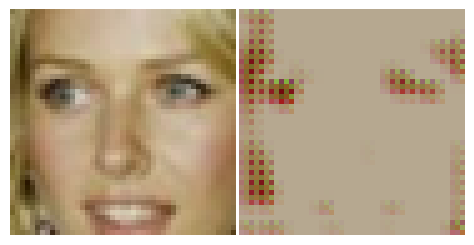

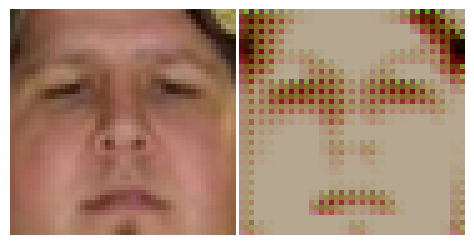

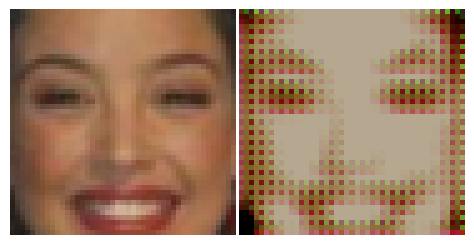

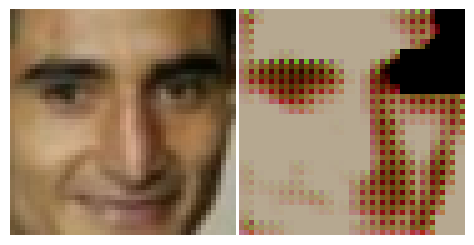

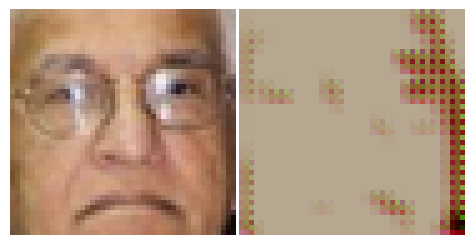

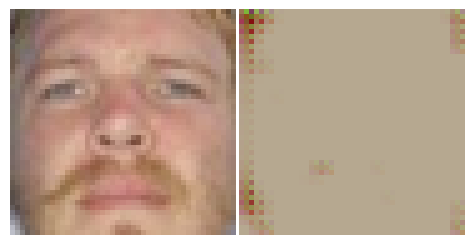

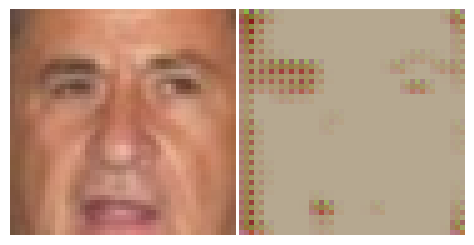

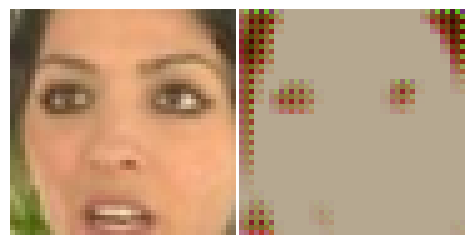

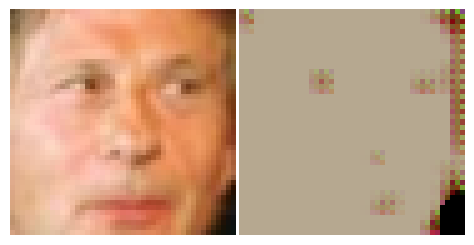

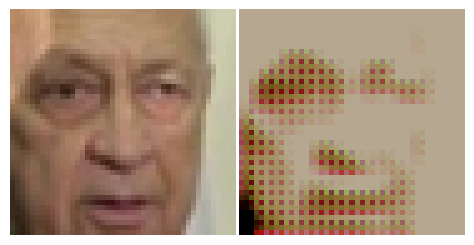

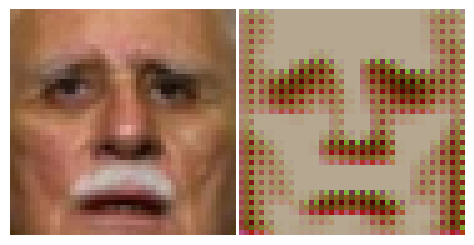

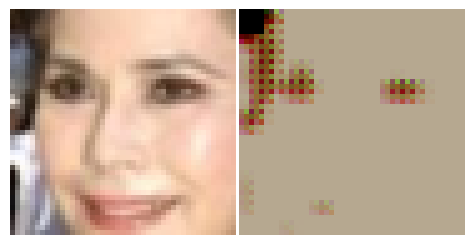

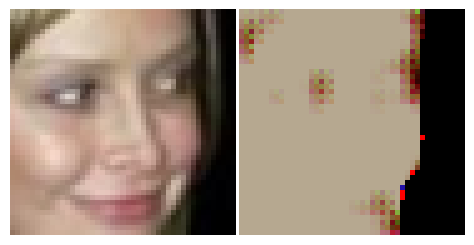

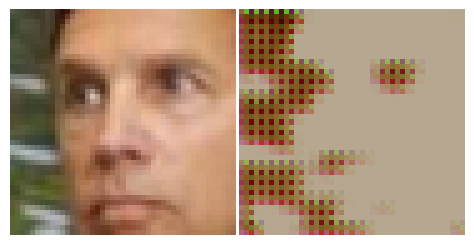

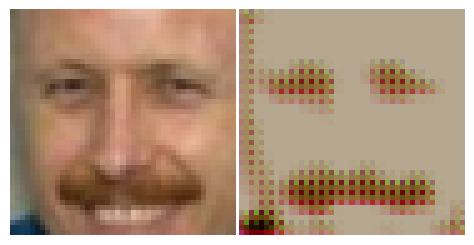

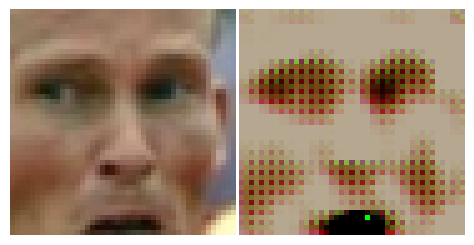

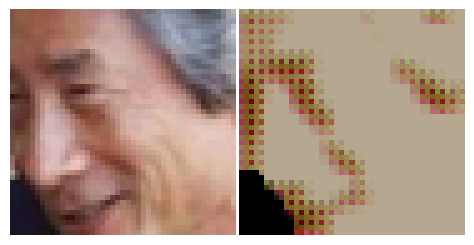

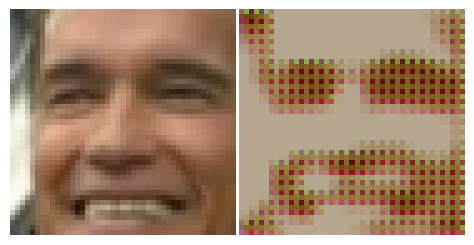

EPOCH: 90 | PHASE: TRAIN | LOSS: 0.02098118025986921


100%|██████████| 83/83 [00:00<00:00, 125.69it/s]


EPOCH: 91 | PHASE: TRAIN | LOSS: 0.018455191189984243
EPOCH: 91 | PHASE: TRAIN | LOSS: 0.016153604856559207


100%|██████████| 83/83 [00:00<00:00, 125.88it/s]


EPOCH: 92 | PHASE: TRAIN | LOSS: 0.015668410370238573
EPOCH: 92 | PHASE: TRAIN | LOSS: 0.016933423333934376


100%|██████████| 83/83 [00:00<00:00, 125.19it/s]


EPOCH: 93 | PHASE: TRAIN | LOSS: 0.019334003172186483
EPOCH: 93 | PHASE: TRAIN | LOSS: 0.023424949408287092


100%|██████████| 83/83 [00:00<00:00, 126.26it/s]


EPOCH: 94 | PHASE: TRAIN | LOSS: 0.025287192629044313
EPOCH: 94 | PHASE: TRAIN | LOSS: 0.027406688690895124


100%|██████████| 83/83 [00:00<00:00, 127.60it/s]

EPOCH: 95 | PHASE: TRAIN | LOSS: 0.02501791161316705


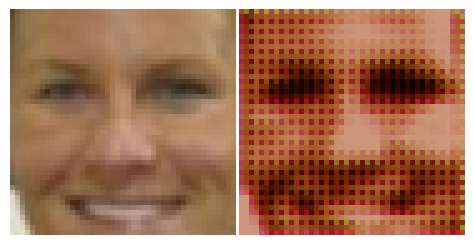

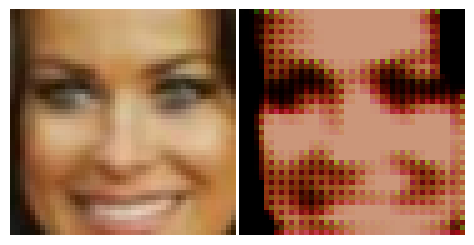

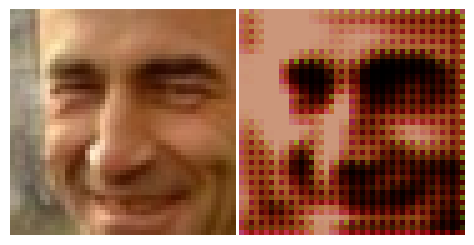

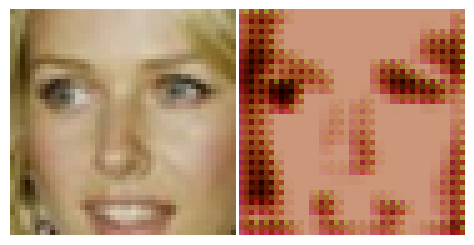

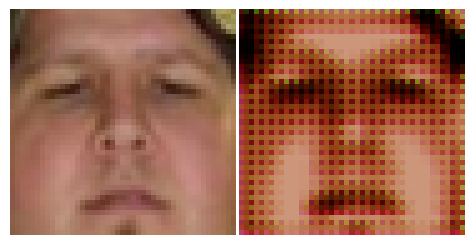

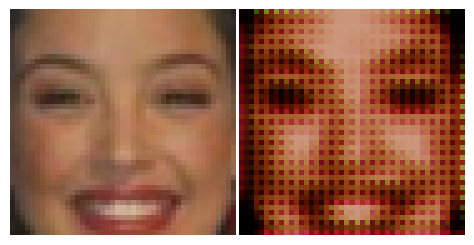

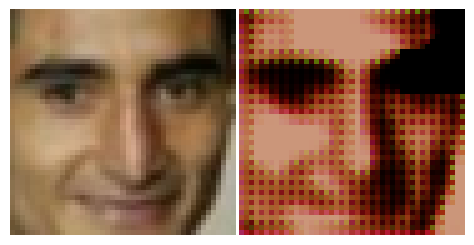

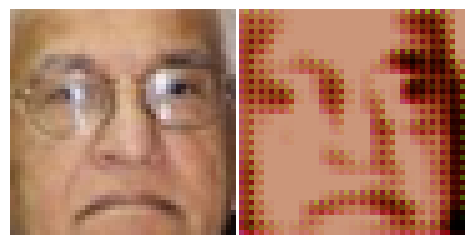

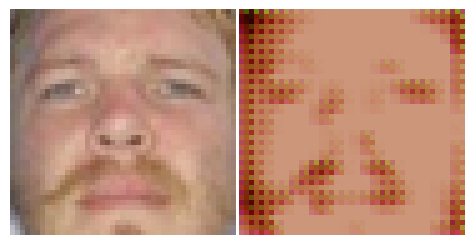

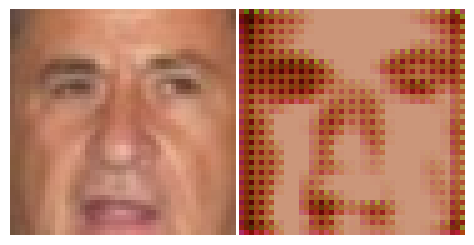

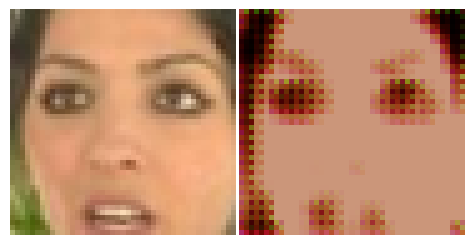

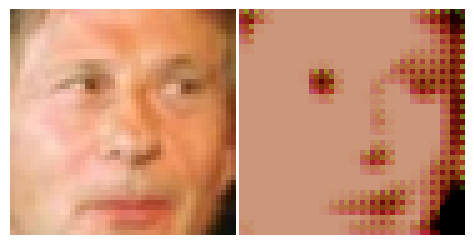

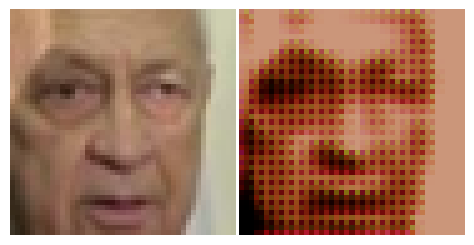

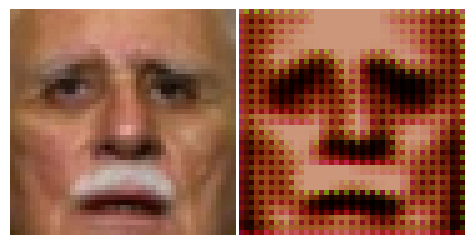

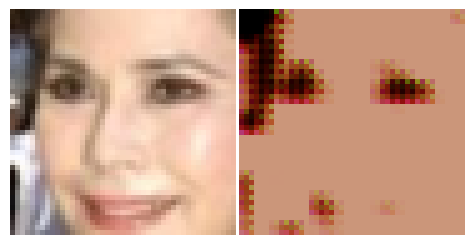

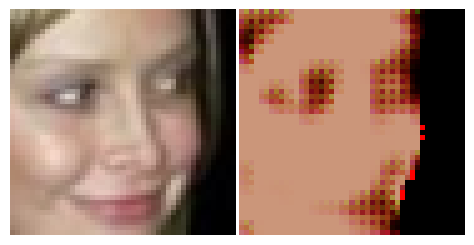

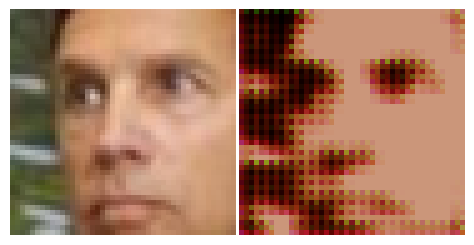

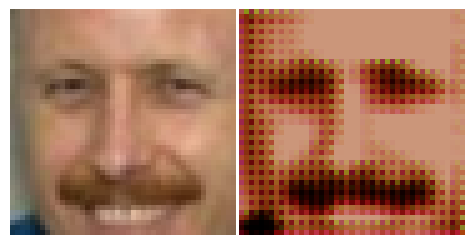

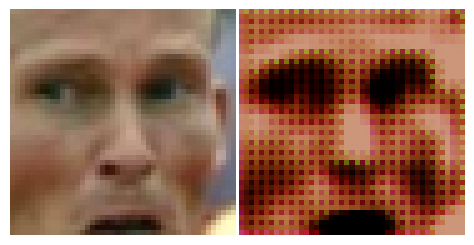

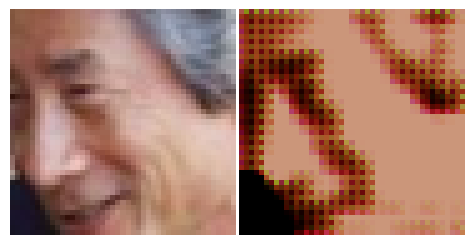

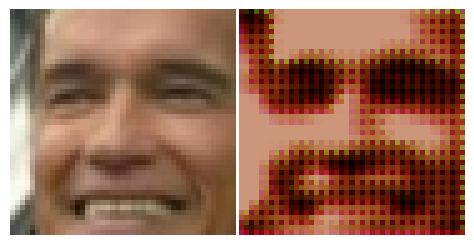

EPOCH: 95 | PHASE: TRAIN | LOSS: 0.02312161729094528


100%|██████████| 83/83 [00:00<00:00, 126.28it/s]


EPOCH: 96 | PHASE: TRAIN | LOSS: 0.019685835700975842
EPOCH: 96 | PHASE: TRAIN | LOSS: 0.018289819182384582


100%|██████████| 83/83 [00:00<00:00, 127.13it/s]


EPOCH: 97 | PHASE: TRAIN | LOSS: 0.017701887693929386
EPOCH: 97 | PHASE: TRAIN | LOSS: 0.018638178528774352


100%|██████████| 83/83 [00:00<00:00, 123.76it/s]


EPOCH: 98 | PHASE: TRAIN | LOSS: 0.019970223464700114
EPOCH: 98 | PHASE: TRAIN | LOSS: 0.021674221381545067


100%|██████████| 83/83 [00:00<00:00, 127.63it/s]


EPOCH: 99 | PHASE: TRAIN | LOSS: 0.023255273273371787
EPOCH: 99 | PHASE: TRAIN | LOSS: 0.024297421443320456


100%|██████████| 83/83 [00:00<00:00, 125.55it/s]

EPOCH: 100 | PHASE: TRAIN | LOSS: 0.024863440902477288


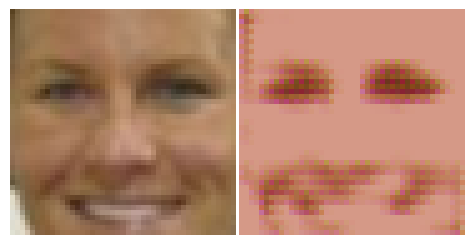

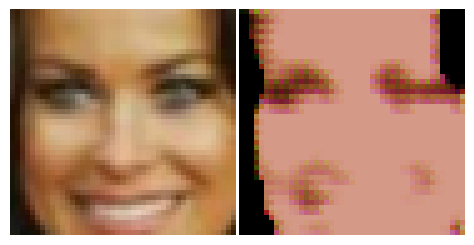

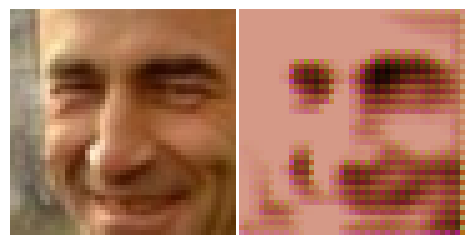

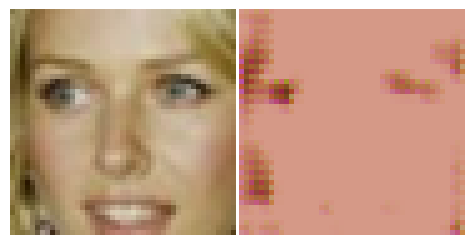

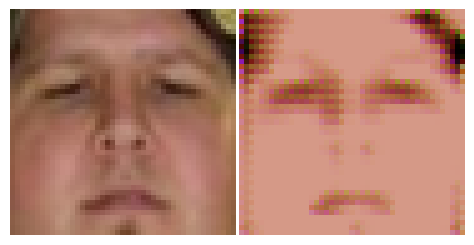

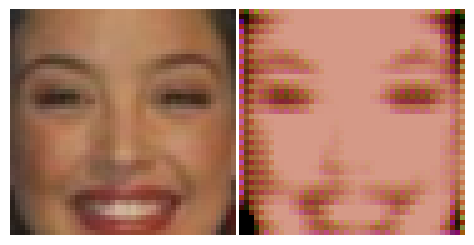

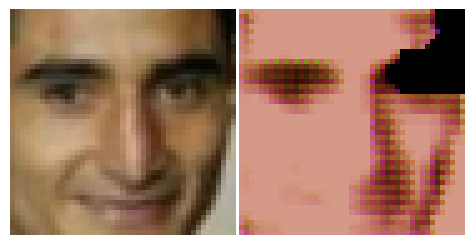

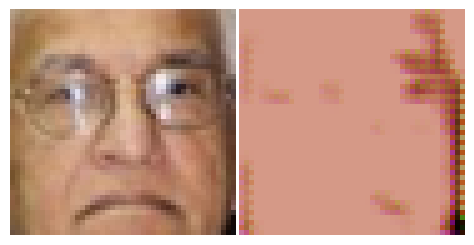

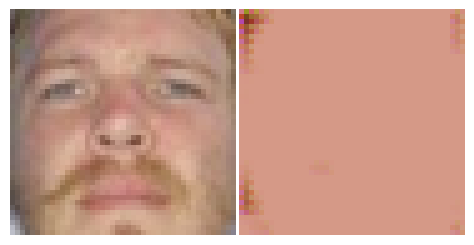

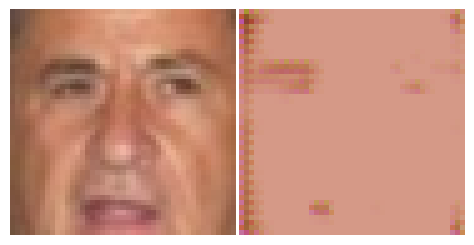

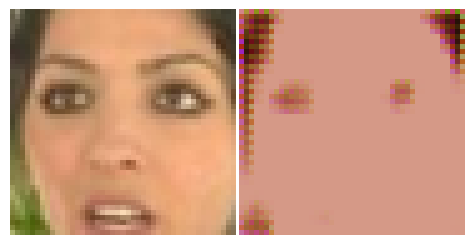

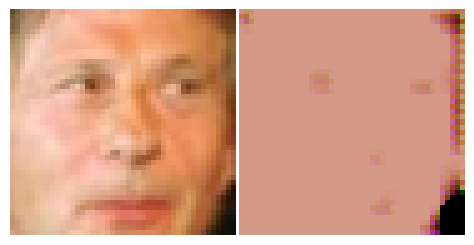

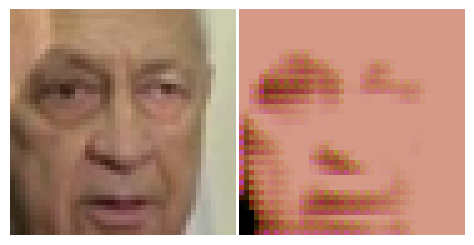

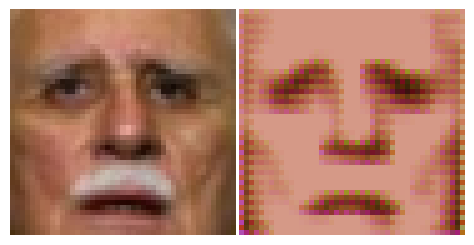

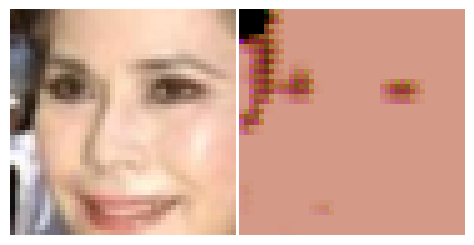

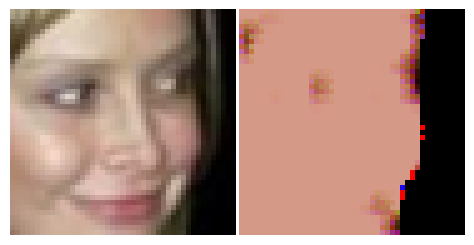

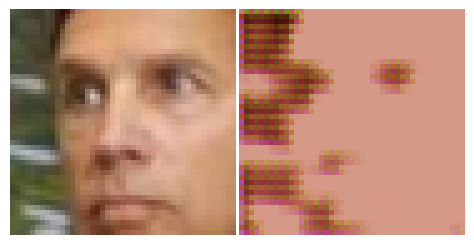

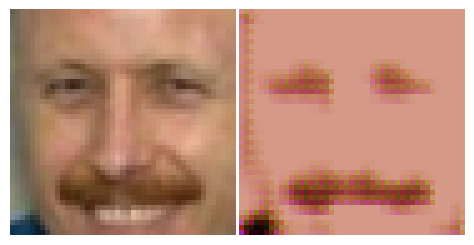

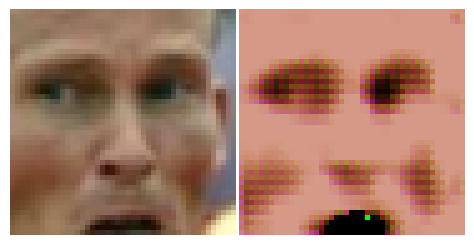

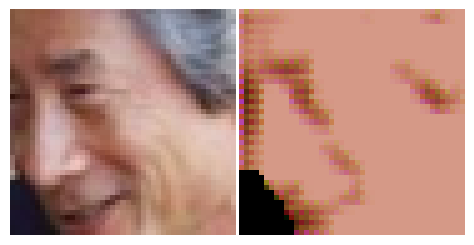

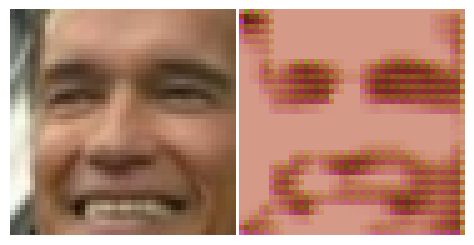

EPOCH: 100 | PHASE: TRAIN | LOSS: 0.024322509233440672


In [39]:
def show_reconstructed(x, reconstructed, n=1, titles=False):
    if x.ndim == 3:
        x = x.unsqueeze(0)
    if reconstructed.ndim == 3:
        reconstructed = reconstructed.unsqueeze(0)
    x = x.detach().cpu()
    reconstructed = reconstructed.detach().cpu()

    b = min(n, x.size(0), reconstructed.size(0))
    cols = 2 * b

    fig, axes = plt.subplots(1, cols, figsize=(2.3 * cols, 2.6))
    if cols == 1:
        axes = [axes]

    for i in range(b):
        # Original
        ax = axes[2*i]
        img = x[i].permute(1, 2, 0).clamp(0, 1)
        ax.imshow(img)
        ax.set_axis_off()
        if titles:
            ax.set_title("Original", fontsize=10)

        # Reconstructed
        ax = axes[2*i + 1]
        rec = reconstructed[i].permute(1, 2, 0).clamp(0, 1)
        ax.imshow(rec)
        ax.set_axis_off()
        if titles:
            ax.set_title("Reconstructed", fontsize=10)

    plt.tight_layout(pad=0.2, w_pad=0.2)
    plt.show()


def train_and_val(model, criterion, optim, loaders, epoch_num, device):
  train_losses = []
  val_losses = []
  for epoch in range(1, epoch_num + 1):
    train_losses_per_epoch = []
    for X_batch in tqdm(loaders["train"]):
      X_batch = X_batch.to(device)
      model.train()
      reconstructed, _ = model(X_batch)
      loss = criterion(reconstructed, X_batch)
      loss.backward()
      optim.step()
      train_losses_per_epoch.append(loss.item())
    mean_epoch_loss = np.mean(train_losses_per_epoch)
    train_losses.append(mean_epoch_loss)
    print(f'EPOCH: {epoch} | PHASE: TRAIN | LOSS: {mean_epoch_loss}')

    with torch.no_grad():
      val_losses_per_epoch = []
      for X_batch in loaders["val"]:
        X_batch = X_batch.to(device)
        model.eval()
        reconstructed, _ = model(X_batch)
        if epoch % 5 == 0:
          show_reconstructed(X_batch[0], reconstructed[0], 1)
        loss = criterion(reconstructed, X_batch.to(device))
        val_losses_per_epoch.append(loss.item())
      mean_epoch_loss = np.mean(val_losses_per_epoch)
      val_losses.append(mean_epoch_loss)
      print(f'EPOCH: {epoch} | PHASE: TRAIN | LOSS: {mean_epoch_loss}')

EPOCHES = 100
train_and_val(autoencoder, criterion, optimizer, loaders, EPOCHES, device)

Давайте посмотрим, как наш тренированный автоэнкодер кодирует и восстанавливает картинки:

\Что вы можете сказать про результат? Видны только общие очертания, но картинка оч далека от реальности(

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэнкодер и получать реконструкцию, а попробуем создать что-то НОВОЕ!

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__ Если вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [ ]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, <latent_space_dim>)
output = <скормите z декодеру>
<выведите тут полученные картинки>

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с атрибутами, скачанный вместе с картинками. В нем указаны имена изображений и присутствубщие атрибуты (улыбки, очки и прочее интересное).

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких.

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей.

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [ ]:
<ваш код здесь>

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... В общем, все, на что хватит фантазии и на что есть атрибуты в `attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [ ]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        <определите архитектуры encoder и decoder
        помните, у encoder должны быть два "хвоста",
        т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x):
        <реализуйте forward проход энкодера
        в качестве ваозвращаемых переменных -- mu и logsigma>

        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        <реализуйте forward проход декодера
        в качестве возвращаемой переменной -- reconstruction>

        return reconstruction

    def forward(self, x):
        <используя encode и decode, реализуйте forward проход автоэнкодера
        в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [ ]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = <напишите код для KL-дивергенции, пользуясь формулой выше>
    return

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = <binary cross-entropy>
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return <соедините тут две компоненты лосса. Mind the sign!>

И обучим модель:

In [ ]:
criterion = loss_vae

autoencoder = VAE()

optimizer = <Ваш любимый оптимизатор>

In [ ]:
<обучите модель на датасете MNIST>

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [ ]:
< тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [ ]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, 100) for i in range(10)])
output = <скормите z декодеру>
<выведите тут полученные картинки>

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [ ]:
class CVAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

    def encode(self, x, class_num):
        # <реализуйте forward проход энкодера
        # в качестве возвращаемых переменных -- mu, logsigma и класс картинки>

        return mu, logsigma, class_num

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, class_num):
        # реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction

        return reconstruction

    def forward(self, x):
        # используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction
        return mu, logsigma, reconstruction

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [ ]:
<тут нужно научиться сэмплировать из декодера цифры определенного класса>

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [ ]:
<ваш код получения латентных представлений, применения TSNE и визуализации>

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [ ]:
noise_factor = 0.5
X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [ ]:
<тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудьте разбить на train/test!>

In [ ]:
<тут проверка, как AE убирает шум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval (2 балла)

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентных представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [ ]:
codes = <поучите латентные представления картинок из трейна>

In [ ]:
# обучаем LSHForest
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [ ]:
def get_similar(image, n_neighbors=5):
  # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
  # прогоняет векторы через декодер и получает картинки ближайших людей

  code = <получение латентного представления image>

  (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

  return distances, X_train[idx]

In [ ]:
def show_similar(image):

  # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

    distances,neighbors = get_similar(image,n_neighbors=11)

    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.cpu().numpy().transpose([1,2,0]))
    plt.title("Original image")

    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

In [ ]:
<тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>